<a href="https://colab.research.google.com/github/rmunoz78/ProyectoIntegrador_MNA_Equipo23/blob/main/Proyecto_Integrador_TFL_Equipo23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelo de sistema de Recomendación Vehículo / Conductor / Caja Seca para TFL
#### Equipo 23:
- Ramón Ariel Iván Muñoz Corona   A01330566

## Importación de Librerías

In [106]:
%matplotlib inline
from geopy.distance import geodesic
import plotly.express as px
import numpy as np
import pandas as pd
import math
import json
import time
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns
import joblib as jl
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import scipy.sparse
from scipy.sparse import csr_matrix
import warnings; warnings.simplefilter('ignore')


from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Importación de Datos

In [107]:
# Lectura de los datos desde el archivo CSV
raw_df = pd.read_csv('/content/drive/MyDrive/Maestria/Proyecto Integrador/Informacion_TFL.csv')
# Copia de los datos a un nuevo data frame con el fin de tener el dataframe
# original en caso de ser necesario
df = raw_df.copy()

In [108]:
# Para revisar que se importó de manera correcta el dataframe, imprimimos los
# primeros 5 renglones. Esto, a su vez, nos permite visualizar la estructura de
# la tabla
df.head()

,No_de_Orden,Cliente,Latitud_Recoleccion,Longitud_Recoleccion,Latitud_Entrega,Longitud_Entrega,Dia,Mes,Ano,Dia_de_la_semana,...,Modelo_Vehiculo_Asignado,Capacidad_Max_Vehiculo_Asignado,ID_Caja_Seca,Capacidad_Max_Caja_Seca,Tipo_de_carga,No_de_Pallets,Peso_de_la_carga,Packaging,Precio_Viaje,Status_de_Orden
0,63,PLAYERAS_SOURCE,19.459257,-99.233282,19.719558,-99.192161,26,4,2022,2,...,1991,22.0,689VT8,22.0,Disfraces,20.0,20.0,Entarimado,4873,Completada
1,900,JASAK,19.499214,-99.167598,19.679743,-99.152783,14,7,2021,3,...,1992,12.0,Integrada_T16,12.0,Electronicos,12.0,12.0,Entarimado,3248,Completada
2,1364,NOVELTY,19.467222,-99.232855,19.289213,-98.954325,11,9,2020,5,...,1999,22.0,852VS5,22.0,Juegos De Mesa,20.0,20.0,Entarimado,4278,Completada
3,1395,NOVELTY,19.467222,-99.232855,19.695617,-99.200431,7,9,2020,1,...,1999,22.0,852VS5,22.0,Juegos De Mesa,20.0,20.0,Entarimado,2300,Completada
4,1396,NOVELTY,19.467222,-99.232855,19.432879,-99.133030,9,9,2020,3,...,1997,12.0,Integrada_T02,12.0,Juegos De Mesa,10.0,10.0,Entarimado,3193,Completada


## Estructura de los datos

In [109]:
# Empezaremos revisando la forma de la tabla para saber con cuantas columnas
# (características de los viajes) y filas (órdenes) tenemos disponibles

df.shape

(7395, 28)

Tenemos 28 features o características de cada viaje y tenemos 7395 viajes registrados.

Con base en esto procedemos a analizar las características de cada columna.

In [110]:
# Con esta función obtenemos la información acerca de cada columna, como por
# ejemplo, tipo de dato, nombre de la columna y el total de los valores nulos
# en la tabla

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7395 entries, 0 to 7394
Data columns (total 28 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   No_de_Orden                             7199 non-null   object 
 1   Cliente                                 7395 non-null   object 
 2   Latitud_Recoleccion                     7395 non-null   float64
 3   Longitud_Recoleccion                    7395 non-null   float64
 4   Latitud_Entrega                         7395 non-null   float64
 5   Longitud_Entrega                        7395 non-null   float64
 6   Dia                                     7395 non-null   int64  
 7   Mes                                     7395 non-null   int64  
 8   Ano                                     7395 non-null   int64  
 9   Dia_de_la_semana                        7395 non-null   int64  
 10  Conductor                               7395 non-null   obje

Podemos ver que la única columna que contiene datos nulos es la del Número de Orden (No_de_Orden), con un total de 196 valores nulos o faltantes.

Sin embargo, esta columna al ser únicamente un identificador, no nos provee ningún elemento estadístico, por lo que podemos removerla.

In [111]:
# Removemos la columna del Número de Orden
df.drop('No_de_Orden', axis=1, inplace=True)

Con base en esta información podemos comenzar a revisar las variables númericas y categóricas para empezar a extraer información.

## Resumen de los Datos

### Variables Numéricas
Comenzaremos con las variables numéricas. Para empezar, realizaremos un análisis estadístico para revisar que las variables cuenten con valores posibles y que podamos revisar si las variables muestran alguna tendencia relevante.

Para realizar el análisis estadístico, utilizaremos la función de "describe" para obtener los valores estadísticos (cuenta, promedio, desviación estandar, mínimo, Q25, Q50, Q75 y máximo).

In [112]:
# La función de describe muestra los valores estadísticos de cada variable
# numérica. Por otra lado, la función T, nos da la transpuesta de la matriz,
# mejorando la visualización de los datos.
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Latitud_Recoleccion,7395.0,19.531612,0.205973,19.283892,19.467222,19.473941,19.499214,23.997913
Longitud_Recoleccion,7395.0,-99.237648,0.374832,-104.644924,-99.232855,-99.228214,-99.167598,-89.592735
Latitud_Entrega,7395.0,19.781831,0.824096,17.983006,19.467222,19.680945,19.697481,28.629067
Longitud_Entrega,7395.0,-99.291176,0.944244,-107.405996,-99.232855,-99.200767,-99.152783,-86.949293
Dia,7395.0,15.953617,8.692576,1.000000,9.000000,16.000000,23.000000,31.000000
Mes,7395.0,7.168357,3.270250,1.000000,4.000000,8.000000,10.000000,12.000000
Ano,7395.0,2021.824341,0.955800,2019.000000,2021.000000,2022.000000,2023.000000,2023.000000
Dia_de_la_semana,7395.0,3.328195,1.616727,1.000000,2.000000,3.000000,5.000000,7.000000
Experiencia_Conductor,7395.0,6.648005,3.680740,0.000000,4.000000,8.000000,10.000000,11.000000
Rendimiento_Promedio_Vehiculo_Asignado,7395.0,2.947478,0.763527,2.000000,2.000000,3.300000,3.300000,5.100000


#### Insights:
* Coordenadas de Longitud y Latitud:
  * La latitud promedio tanto de recolección, como de entrega esta al rededor de 19.45 con una desviación estandar de aproximadamente 1.25, mostrando que la mayoría de las locaciones están agrupadas alrededor del promedio, con una dispersión muy baja.
  * La longitud promedio para la recolección y entrega está aproximadamente en -99.24, con una desviación muy baja (aproximadamente 0.655). Lo que sugiere que las locaciones están bastante juntas.
  * Si obtuvieramos una locación promedio sería a un lado del Campo Militar  1-A de SEDENA en la CDMX.
  * Con estas columnas es facil obtener el la distancia que se recorrió para el viaje.
* Información sobre las fechas:
  * El día del mes promedio es aproximadamente 16, con una desviación estandar de 8.69, mostrando que se distribuyen los viajes de manera equitativa a lo largo del mes.
  * El mes promedio es Julio (mes 7), con una desviación estandar de 3.27. Si vemos los cuantiles, podemos ver que los meses más cargados son de agosto a diciembre.
  * El año promedio es 2021. Basado en los cuantiles podemos decir que la mayoría de los datos son de entre 2019 y 2023.
  * El día promedio es el miercoles, con una desviación estandar de aproximadamente 1.6, mostrando que estan distribuiods equitativamente los viajes a lo largo de la semana.
* Información sobre Conductores y Vehículos
  * El nivel de experiencia promedio de los conductores es de 6.65 años, sin embargo su desviación estandar es bastante elevada, con 3.68 años, mostrando que los un rango bastante amplio en el nivel de experiencia. Esto nos habla de una posible falta de retención de personal.
  * El año promedio de los vehículos es 1996. Si vemos los cuantiles, podemos ver que la gran mayoría de los vehiculos son anticuados, siendo en su mayoría de entre el año 1981 y 1997.
  * El peso máximo soportado por las unidades es de 17.58 Toneladas, sin embargo tienen una desviación estandar alta, de aproximadamente 6.08 toneladas, mostrando que hay una amplia diversidad en la foltilla para diferentes capacidades.
  * El rendimiento promedio es de aproximadamente 3 km por litro, lo que nos habla de un rendimiento bajo, probablemente por el nivel de carga.
* Información del cargamento:
  * El peso promedio por viaje es de 13.8 Toneladas, con una desviación de 5.6 toneladas aproximadamente. Esto nos dice que existe una buena variedad de pesos en cada viaje.
  * Podemos ver una correlación fuerte entre el número de pellets y el peso del viaje. Con un número de pellets de aproximadamente 14, igualmente con una desviación estandar elevada de 6 pellets, mostrando una buena variedad de número de pellets por viaje.
  * El precio promedio por viaje es de \$3787.24 MXN, con una desviación estandar elevada, de \$5197.03 MXN, sugiriendo que los precios varian mucho entre clientes. Probablemente valdría la pena estandarizarlos.
  * Podemos ver que las capacidades máximos son una calca una de la otra, por lo que valdría la pena desechar una de las dos variables.

### Variables de Tipo Objeto
Una vez analizadas las variables de tipo numéricas, podemos pasar con las de tipo objeto. Para este análisis revisaremos con qué valores cuenta cada variable para revisar que no existan valores erroneos o inválidos. De igual manera nos brindará un insight sobre las variables.

In [113]:
# Esta función está diseñada para imprimir cada variable de tipo objeto y que
# a su vez se impriman los valores de cada variable, junto con el conteo de
# cada valor.

for i in df.describe(include=['object']).columns:
    print('Unique values in',i, 'are :')
    print(df[i].value_counts())
    print('*'*50)

Unique values in Cliente are :
Cliente
NOVELTY                   1939
JASAK                     1829
PLAYERAS_SOURCE           1638
JESSY                     1367
PENINSULA_ORIENTAL         357
APLIN                      122
MUEBLES_TRICK               76
MULTIBOLSAS                 60
COLECCIONES_DEPORTIVAS       7
Name: count, dtype: int64
**************************************************
Unique values in Conductor are :
Conductor
Externo                          1405
Jose Martin Regino Lopez          805
Maradonio Tirso Montano           711
Jose Luis Jimenez de la Cruz      695
Ernesto Hernandez Bernal          634
Gabriel Reyes                     614
Miguel Perez Santarosa            612
Jose Daniel Hernandez Martell     410
Edgar Arreola                     317
Nazario Cruz de la Cruz           310
Ivan Montero                      294
Angel                             174
Alan Gil Chavez                   121
Yair Gabriel Flores Lira           96
Agustin                       

#### Insights:
* Clientes
  * Los clientes con mayor número de viajes son NOVELTY (1939 viajes), JASAK (1829 viajes)y PLAYERAS_SOURCE (1638 viajes)
  * Existe una diferencia significativa entre los clientes principales y el resto de los clientes, lo que nos habla de una concentración del negocio en sus clientes más grandes.
* Conductor
  * Los viajes son mayormente realizados por Jose Martin Regino Lopez (805 Viajes), Maradonio Tirso Montaño (711 Viajes) y Jose Luis Jimenez de la Cruz (695 Viajes).
  * Existe una concentración importante de los viajes realizados por conductores externos. 1405 de 7395 Viajes (19%). Lo que nos habla de una posible falta de capacidad de la empresa. Probablemte requiera más conductores o conductores con más experiencia.
  * Existe una distribución inicuo de los viajes entre conductores. Probablemente por sus status dentro de la empresa o por sus años de experiencia.
  * 6532 de los viajes fueron realizados por choferes aún activos en la empresa y 1043 por choferes que no continuan en la empresa.
* Tipos de Servicios Solicitado:
  * El servicio más solicitado es el manejo y transporte de mercancía. Valdría la pena revisar si estos también son los más redituables.
  * Existe una gran diferencia entre los servicios solicitados para torton y trailer, que para camioneta.
  * Existe una gran similitud entre los vehículos solicitados y los vehículos asignados. Sin embargo, podemos ver la existencia de externos en los vehículos asignados. Estos son debido a que por falta de capacidad operacional, se asignan camiones de empresas hermanas para cubrir la necesidad del viaje.
  * La distribución de los ID de los vehiculos asignados y los ID de tipos de caja es identico, lo que nos dice que probablemte nunca se han cambiado las cajas de sus vehiculos.
* Información de la carga:
  * El tipo de carga más transportada son eletrónicos y juegos de mesa.
  * La mayor parte de las mercancias están empaquetadas utilizando pallets.
* Estatus de Orden:
  * El 96% de los viajes se completaron, lo que nos indica un buen nivel de servicio por parte de TFL.

Ya analizados estos datos y revisar que estén correctos, podemos proceder al análisis univariable. Pero antes, valdría la pena agregar una variable; la distancia del viaje. Esta nueva variable nos da un mayor insight sobre una posible correlación entre distancia y precio.

In [114]:
# Esta función calcula la distancia entre los puntos de recolección y entrega
# utilizando la librería de geodesic
def calculate_distance(row):
    origin = (row['Latitud_Recoleccion'], row['Longitud_Recoleccion'])
    delivery = (row['Latitud_Entrega'], row['Longitud_Entrega'])
    return geodesic(origin, delivery).kilometers

# Se aplica la función a cada fila de la tabla
df["distancia_km"] = df.apply(calculate_distance, axis=1)

Una agregada la nueva variable y terminar de revisar que los datos estén correctos, podemos proceder al análisis univariable. Esto nos va a dar un mayor nivel de insight sobre cómo se comporta cada variable y si es que existe algún patrón o comportamiento.

## Análisis Univariable
### Variables Numéricas
Para revisar las variables numéricas generaremos un histograma, junto con un diagrama de caja, resaltando su promedio y la mediana. Esto nos permitirá ver la distribución de los datos, visualizar si tenemos outliers y ver si tenemos alguna tendencia.

In [115]:
# Esta función, como se explicó, nos permite visualizar la distribución de los
# datos numéricos, si es que existen outliers y donde se encuentra su valor
# medio y su mediana

def plot_histogram_boxplot(data, col_name, figsize = (5,5), bins = None):
  feature = data[col_name]
  f2, (ax_box2, ax_hist2) = plt.subplots(nrows = 2,
                                         gridspec_kw = {"height_ratios": (.25, .75)},
                                         figsize = figsize)

  ax_box2.set_title(col_name).set_position([0.5, -3])
  sns.boxplot(feature, ax=ax_box2, showmeans=True, color='violet', orient="h")
  ax_box2.set_xlabel('')
  sns.distplot(feature, kde=False, ax=ax_hist2, bins=bins,color = 'orange') if bins else sns.distplot(feature, kde=False, ax=ax_hist2,color='tab:cyan') # For histogram
  ax_hist2.axvline(np.mean(feature), color='purple', linestyle='--')
  ax_hist2.axvline(np.median(feature), color='black', linestyle='-')
  ax_hist2.set_ylabel('Total de Viajes')

# Esta función funciona con el mismo principio que plot_histogram_boxplot,
# sin embargo está diseñada para poder tener más de una gráfica en el mismo
# bloque. Visualizando de mejor manera las gráficas.
def multi_histogram_boxplot(feature, ax, ax2, bins=None):
    sns.boxplot(feature, ax=ax, showmeans=True, color='violet', orient="h")
    if bins:
        sns.distplot(feature, kde=False, ax=ax2, bins=bins, color='tab:cyan')
    else:
        sns.distplot(feature, kde=False, ax=ax2, color='tab:cyan')
    ax2.set_xlabel('')
    ax2.axvline(np.mean(feature), color='purple', linestyle='--')
    ax2.axvline(np.median(feature), color='blue', linestyle='-')

# Esta funcion crea un mapa alrededor con los data series de coordenads
def plot_location(data, lat_col, lon_col):
  fig = px.scatter_mapbox(data, lat=lat_col, lon=lon_col, hover_name="Cliente", hover_data=["Dia", "Mes", "Ano"],
                        color_discrete_sequence=["fuchsia"], zoom=3, height=300)
  fig.update_layout(mapbox_style="open-street-map")
  fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
  fig.show()

# Esta función permite poner varias gráficas del mismo tipo en una matriz
# permitiendo visualizarlas todas en un sólo bloque
def create_grid_of_plots(data, cols, figsize=(15, 5), bins=None):
  full_rows = math.floor(len(cols)/3)
  last_row_elems = len(cols) % 3
  for i in range(0,full_rows*3,3):
    pltcols = cols[i:i+3]
    fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize=figsize, gridspec_kw={"height_ratios": (0.25, 0.75)})
    fig.subplots_adjust(hspace=0.18)
    for j in range(3):
      col = pltcols[j]
      ax = axes[0, j%3]
      ax2 = axes[1, j%3]
      feature = df[col]
      multi_histogram_boxplot(feature, ax, ax2, bins)
      ax.set_title(col).set_position([0.5, -3])
    plt.show()
  if (last_row_elems > 0):
    pltcols = cols[len(cols)-last_row_elems:]
    if len(pltcols) == 1:
      plot_histogram_boxplot(df,pltcols[0])
    else:
      fig, axes = plt.subplots(nrows = 2, ncols = len(pltcols), figsize = (len(pltcols)*5, 5), gridspec_kw={"height_ratios": (0.25, 0.75)})
      print(axes)
      fig.subplots_adjust(hspace=0.15)
      for j in range(len(pltcols)):
        col = pltcols[j]
        ax = axes[0, j%len(pltcols)]
        ax2 = axes[1, j%len(pltcols)]
        feature = df[col]
        multi_histogram_boxplot(feature, ax, ax2, bins)
        ax.set_title(col).set_position([0.5, -3])
      plt.show()

### Puntos de Recolección

In [116]:
plot_location(df, "Latitud_Recoleccion","Longitud_Recoleccion")

- Este análisis a pesar de ser multivariable puede ser tomado como uno sólo debido a que estas dos variables nos muestran la locación de los puntos de recolección
- Podemos notar que la mayoría de las recolecciones son realizadas dentro del area metropolitana (EDOMEX y CDMX)
- Existen algunos "Outliers" de recolecciones realizdos en Querétaro, Mérida, Durango y Jalisco. Sin embargo, son viajes posibles.

### Puntos de Entrega

In [117]:
plot_location(df, "Latitud_Entrega","Longitud_Entrega")

- Estas dos variables (Latitud de Entrega y Longitud de Entrega) sufren del mismo problema que el de los puntos de recolección; pueden ser tomados como una sola variable.
- En este caso, las entregas podemos ver que están más repartidas a lo largo de toda la republica
- A pesar de verse una dispersion mayor, podemos ver que existe de cualquier manera una concentración fuerte alrededor del area metropolitana y sus estados colindantes

### Fechas de los viajes


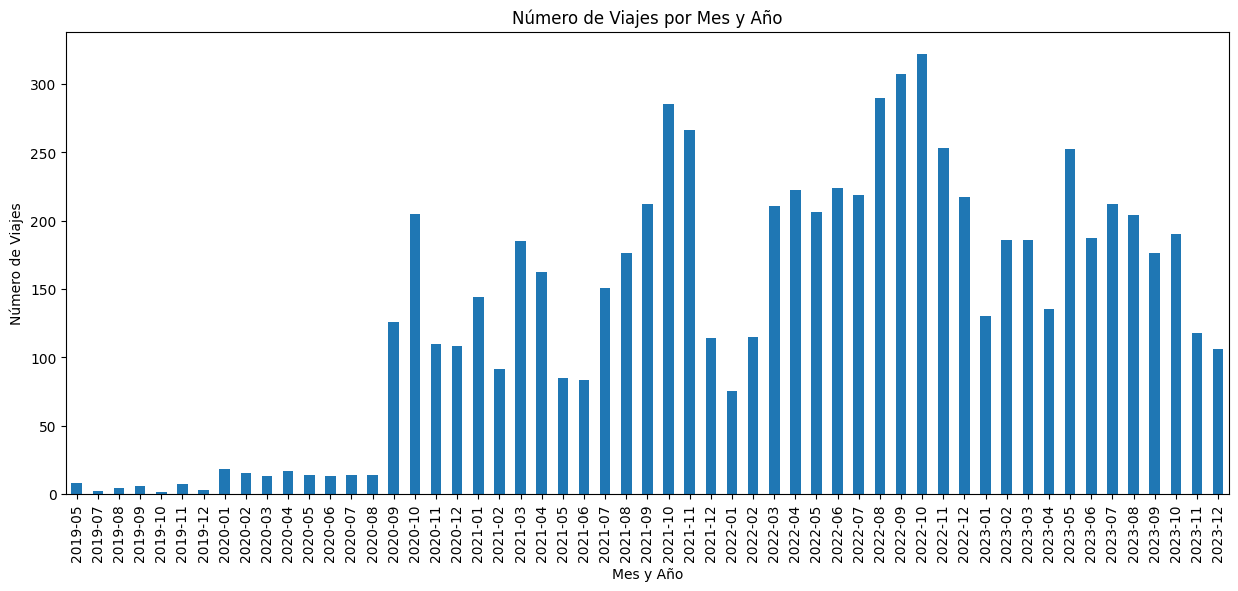

In [118]:
# Primero generamos un dataframe que contenga la variable en conjunto de Fecha
df_fechas = df[["Ano","Mes","Dia",]].copy()
df_fechas['Fecha'] = df_fechas['Ano'].astype(str) + '-' + df_fechas['Mes'].astype(str) + '-' + df_fechas['Dia'].astype(str)
df_fechas['Fecha'] = pd.to_datetime(df_fechas['Fecha'])

# Agrupamos las fechas por mes y año y contamos los viajes. Esto para facilitar
# la visualización de los datos
df_fechas['Mes y Año'] = df_fechas['Fecha'].dt.to_period('M')
conteo_viajes = df_fechas.groupby('Mes y Año').size()
conteo_viajes.head()

# Mostramos la gráfica
plt.figure(figsize=(15, 6))
conteo_viajes.plot(kind='bar')
plt.xlabel('Mes y Año')
plt.ylabel('Número de Viajes')
plt.title('Número de Viajes por Mes y Año')
plt.show()

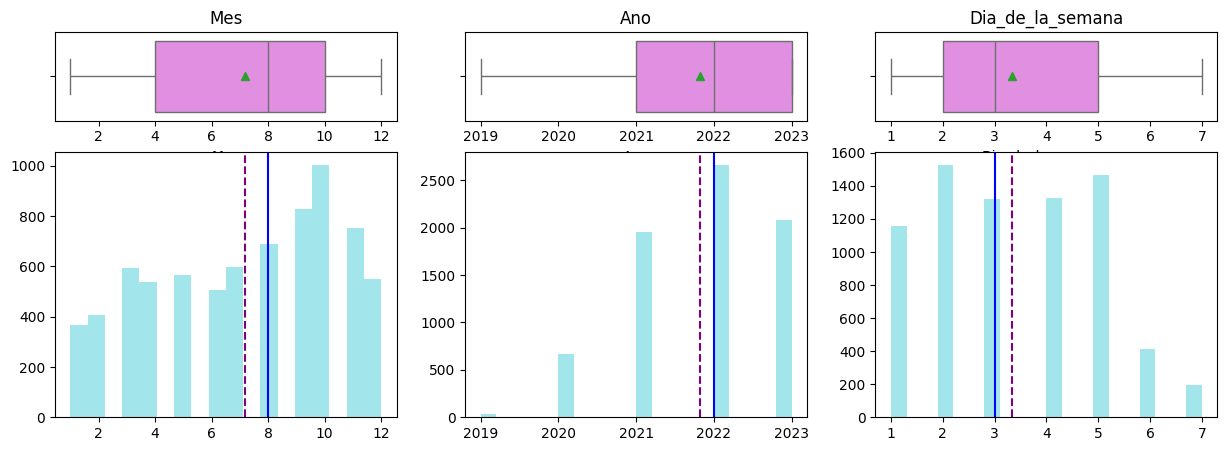

In [119]:
create_grid_of_plots(df, ["Mes","Ano","Dia_de_la_semana"])

- Con base en estas gráficas podemos ver que 2019 y 2020 tuvo una baja importante en viajes. Esto es debido a que anteriormente los registros eran en carpetas físicas, las cuales se perdieron debido a un incendio en la oficina.
- Podemos notar que entre Agosto y Noviembre, existe un patrón de una alza de viajes, lo que puede estar relacionado por la preparación de las empresas al fin de año. Esto puede significar una ventaja para TFL ya que puede prepararse para la carga de trabajo para estas fechas.
- El año con una mayor concentración de viajes fue 2022. Valdría la pena revisar las posibles causas de la baja para 2023. Ya sea por fuga de clientes o algún otro factor como alza de precios.
- Los días entre semana (lunes a viernes) son los días con mayor nivel de trabajo. Sábados y Domingos son los más bajos. El martes es el día con mayor nivel de viajes, seguido del Viernes.

#### Experiencia del Conductor

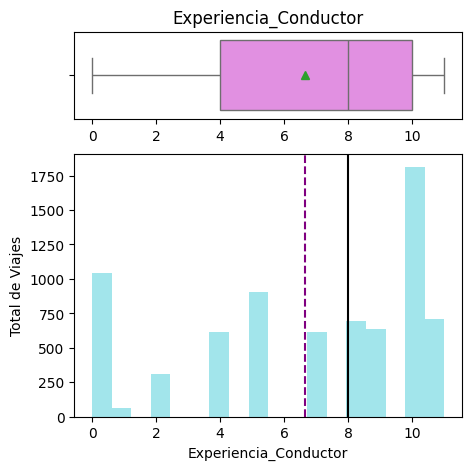

In [120]:
plot_histogram_boxplot(df, "Experiencia_Conductor")

- Existe un patrón muy particular aquí. Los choferes con una experiencia de 10 años, son los que más viajes han realizado. Pero, en segundo lugar, los choferes sin experiencia (0 años) son los segundos que hacen más viajes. Esto genera una pregunta ¿Existe algún problema con los datos de los conductores con 0 años de experiencia? Probablemente, esto se resuelva en el análisis multivariable.

## Rendimiento Promedio del Vehículo

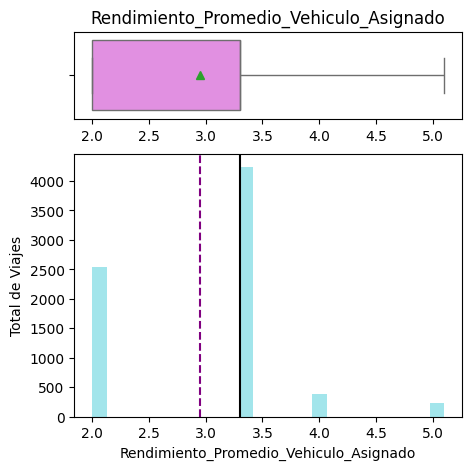

In [121]:
plot_histogram_boxplot(df, "Rendimiento_Promedio_Vehiculo_Asignado")

- Podemos ver que existe una mayor concentración de viajes con bajo y medio rendimiento (2.0 y 3.3 respectivamente). Lo que nos habla de posibles problemas, como malos hábitos de manejo, robo de diesel, falta de mantenimiento de las unidades, unidades viejas, etc.
- Valdría la pena explorar en el análisis multivariable si existe alguna correlación entre la experiencia del conductor y el rendimiento, al igual que el rendimiento y el peso de la carga, o incluso el rendimiento y el vehículo seleccionado.

## Capacidades Máximas del Vehículo y Caja

[[<Axes: > <Axes: >]
 [<Axes: > <Axes: >]]


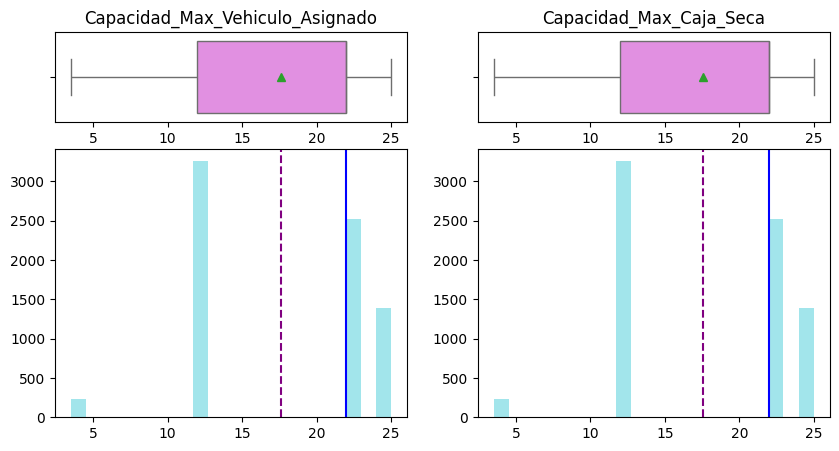

In [122]:
create_grid_of_plots(df, ["Capacidad_Max_Vehiculo_Asignado","Capacidad_Max_Caja_Seca"])

- Como podemos ver en las gráficas, son idénticas, por lo que podemos desechar una de las dos. En este caso se optó por la capacidad máxima del vehículo asignado.
- Podemos ver que la mayoría de los viajes son realizados con un vehículo que soporta un tonelaje de aproximadamente 13 Toneladas. En segundo lugar tenemos un tonelaje más alto, de aproximadamente 23 toneladas.

In [123]:
# Removemos la columna con datos identicos
df.drop('Capacidad_Max_Vehiculo_Asignado', axis=1, inplace=True)

### Número de Pellets y Peso de la Carga

[[<Axes: > <Axes: >]
 [<Axes: > <Axes: >]]


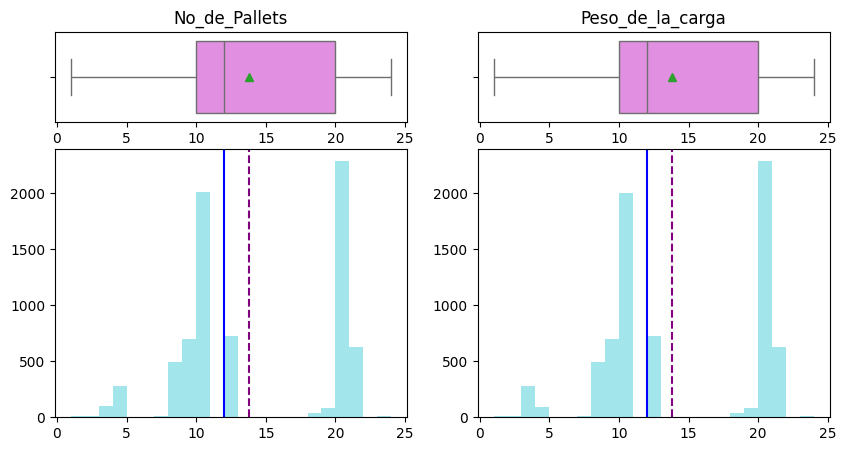

In [124]:
create_grid_of_plots(df, ["No_de_Pallets","Peso_de_la_carga"])

- Podemos ver que de igual manera, estas dos variables son prácticamente idénticas, por lo que podemos precindir de una de ellas para reducir la complejidad del modelo. En este caso desecharemos el No. de Pellets.
- Podemos ver que la mayoría de los viajes llevan cargas de 20 y 13 toneladas.
- El promedio de peso por viaje es de 13 toneladas, lo que hace match con el promedio de carga máxima soportada.

In [125]:
# Removemos la columna con datos identicos
df.drop('No_de_Pallets', axis=1, inplace=True)

### Precio del Viaje

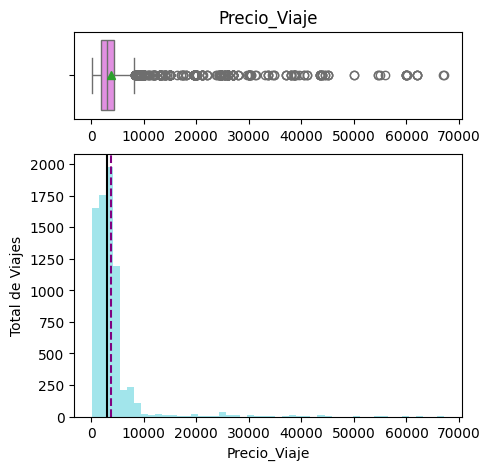

In [126]:
plot_histogram_boxplot(df, "Precio_Viaje")

- Podemos ver que la mayoría de los viajes tienen un precio máximo de \$10,000
- Muy pocos viajes son de más de \$10,000.
- Los precios parecieran no estar estandarizados, por lo que valdría la pena revisar los motivos para esto.
- El precio promedio por viaje es de aproximadamente de \$3,500

### Distancia de los viajes

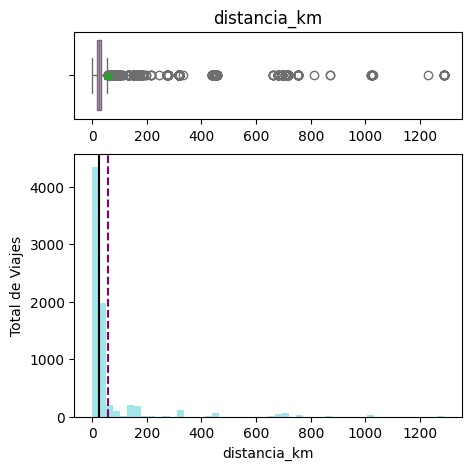

In [127]:
plot_histogram_boxplot(df, "distancia_km")

- Podemos ver que existe una forma muy similar entre la distancia viajada vs. el precio de cada viaje. Valdría la pena revisitar esto con mayor detalle en el análisis multivariable.
- La mayor parte de los viajes son de menos de 250km


Hecho este análisis, procederemos a hacer lo mismo para las variables categóricas o tipo objeto.

## Variables Tipo Objeto

In [128]:
# Esta función nos permite generar la gráfica de barras para una variable
# categórica, mostrando su porcentaje en la parte superior de la gráfica
def perc_on_bar(data,z, ax2 = None):
    total = len(data[z])
    if ax2 == None:
      plt.figure(figsize=(15, 6))
      ax = sns.countplot(data= data, x = z,palette='Paired')
    else:
      ax = sns.countplot(data= data, x = z,ax = ax2,palette='Paired')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x()
        y = p.get_y() + p.get_height()+15
        ax.set_title(z)
        ax.set_ylabel('Total de Viajes')
        ax.annotate(percentage, (x, y), size = 10)

# Esta función genera una matriz de gráficas de barras
def create_grid_of_perc_on_bar(data, cols, figsize=(30, 10)):
    num_rows = int(np.ceil(len(cols) / 3))
    if len(cols) < 3:
      num_cols = len(cols)
    else:
      num_cols = 3

    plt.figure(figsize=figsize)
    fig, axes = plt.subplots(nrows = num_rows, ncols=num_cols, figsize=figsize)
    if num_rows == 1:
      for i, col in enumerate(cols):
        ax2 = axes[i]
        perc_on_bar(data, col, ax2)

    else:
      row = -1
      for i, col in enumerate(cols):
          if i%3==0:
            row+=1
          print(row,i%3)
          ax2 = axes[row,i%3]
          perc_on_bar(data, col, ax2)

    plt.tight_layout()
    plt.show()

### Cliente

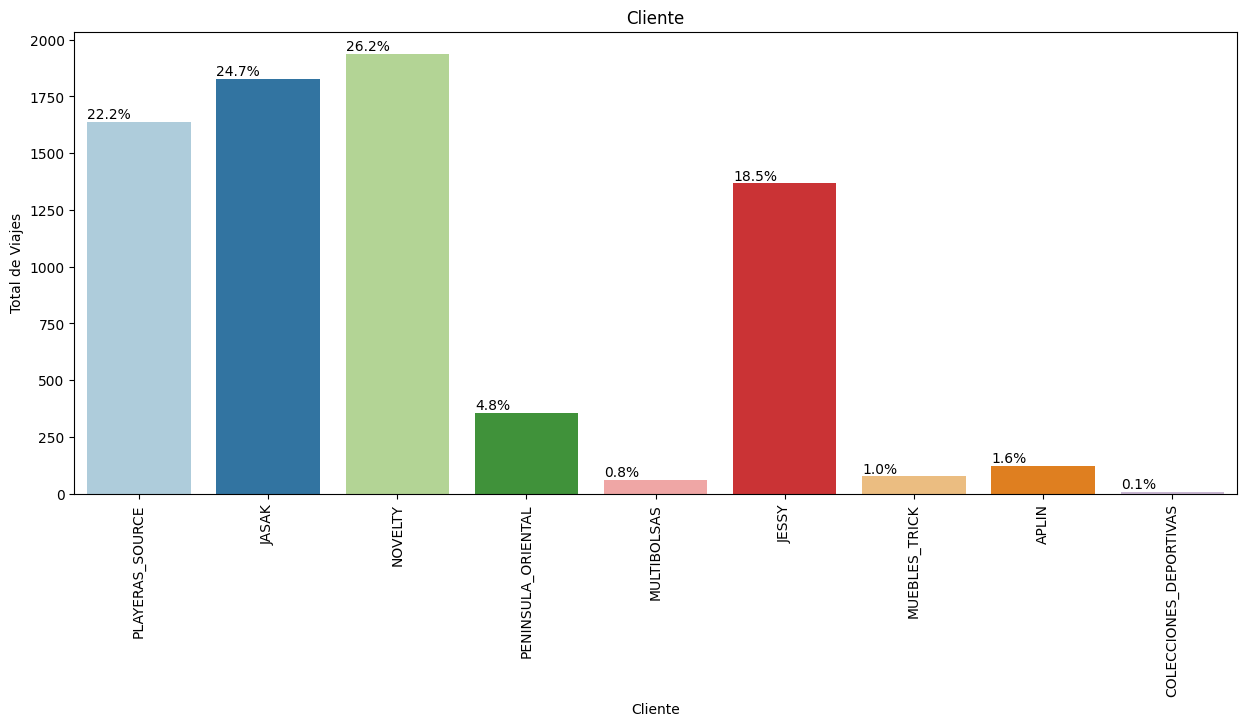

In [129]:
perc_on_bar(df, "Cliente")

- Como se mencionaba en puntos anteriores, existe una diferencia significativa en el porcentaje de viajes de los clientes prioritarios y los secundarios.
- NOVELTY cuenta con el 26.2% del total de viajes
- Su cliente con menos viajes es colecciones deportivas con el 0.1%

### Conductor

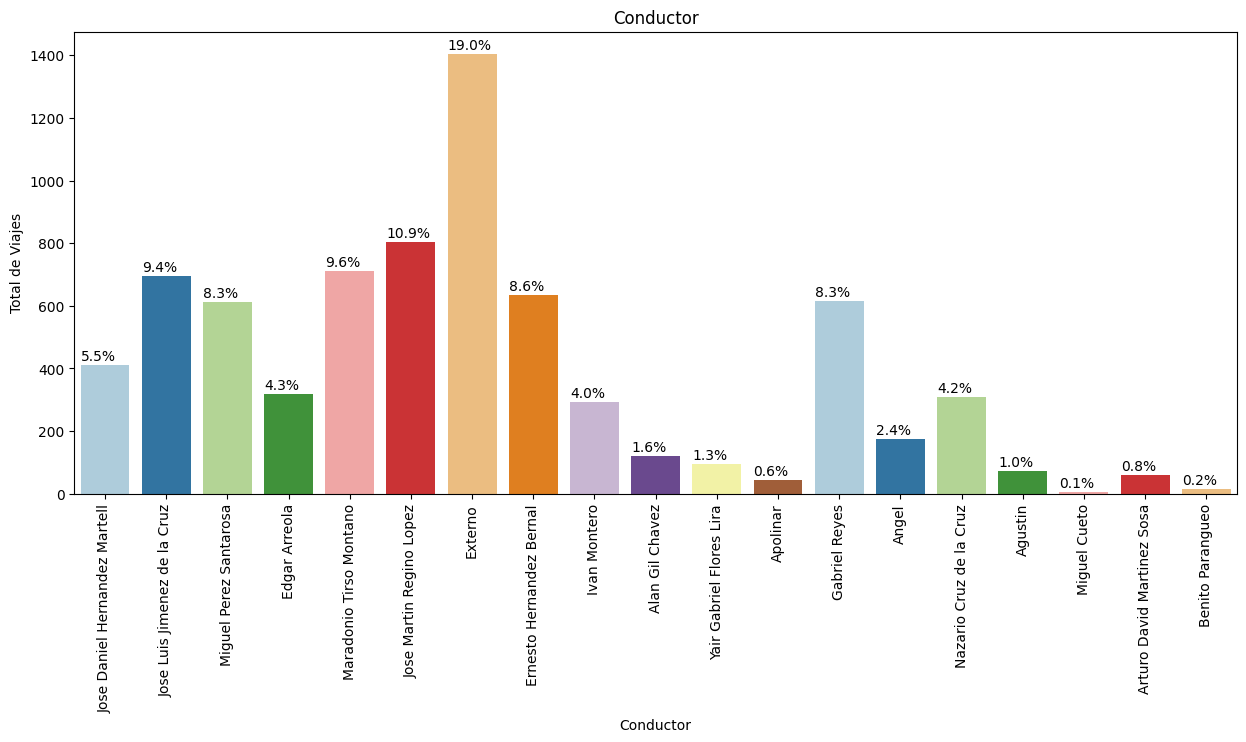

In [130]:
perc_on_bar(df, "Conductor")

- En esta gráfica podemos ver que el 19% de los viajes son realizados por conductores externos, lo que nos habla de una falta de capacidad para completar las operaciones. Esto puede ser por fuga de personal o por un crecimiento estancado de la empresa.
- El conductor con mayor porentaje de viajes es Jose Luis Jimenez de la Cruz con el 9.4%
- El conductor con menor porcentaje de viajes es Miguel Cueto con 0.1%
- Hay que revisar el status de cada conductor a ver si existe alguna correlación entre con su porcentaje de viajes.

### Status de Conductor

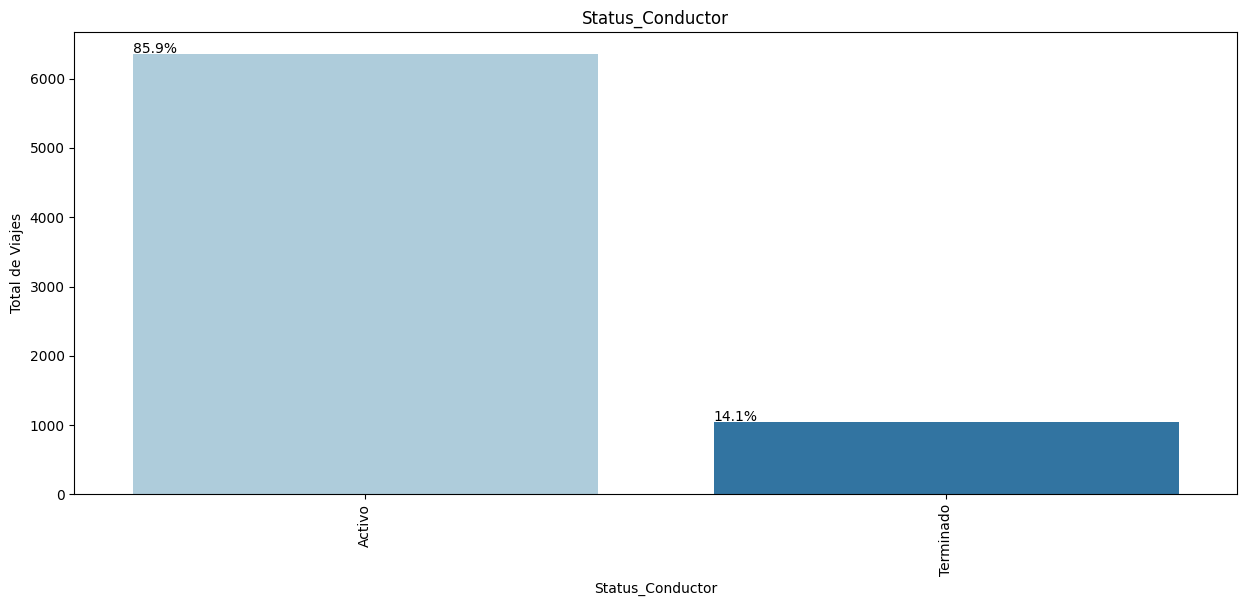

In [131]:
perc_on_bar(df, "Status_Conductor")

- El 85.9% de los viajes realizados fueron hechos por conductores aún activos
- Valdría la pena revisar si existe alguna correlación entre los conductores terminados y los viajes incompletos.

## Tipo de Servicio Solicitado

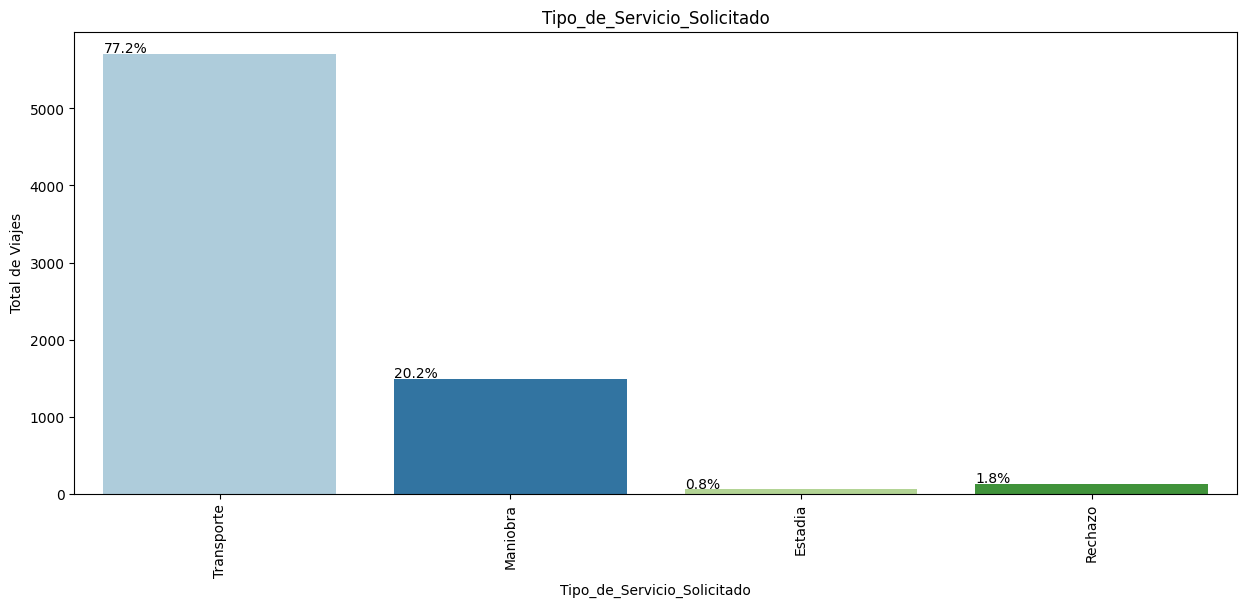

In [132]:
perc_on_bar(df, "Tipo_de_Servicio_Solicitado")

- Podemos ver que los principales servicios de TFL son el transporte de mercancías (77.2%) y las maniobras (20.2%)
- La estadía y el rechazo tienen un diferencia abismal comparado con el resto de los servicios. Esto es debido a que estos son complementos de los servicios de Transporte y Maniobra

### Tipo de Vehiculo Solicitado

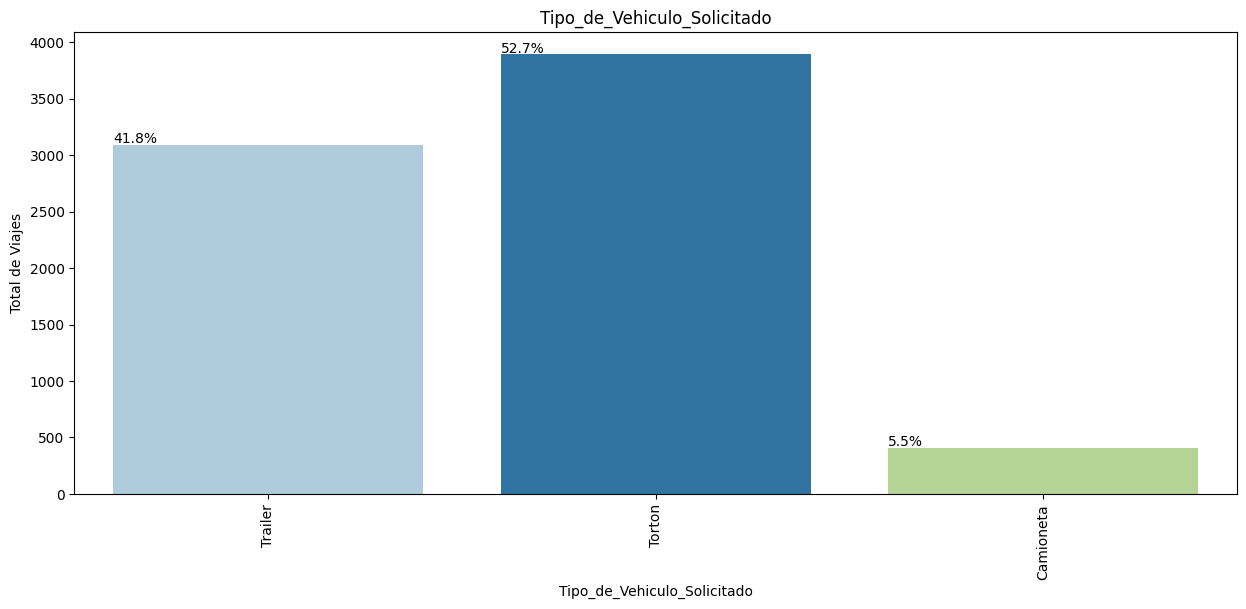

In [133]:
perc_on_bar(df, "Tipo_de_Vehiculo_Solicitado")

- El tipo de vehículo que más se solicita son los torton (52.7%) y trailer con 41.8%, esto puede ser por el tipo de cargamento y el peso de este, que manejan los clientes con mayor frecuencia.
- Esto puede ser un indicador sobre qué tipo de vehículos son los que más unidades deben existir en la flotilla
- En el caso de la camioneta, valdría la pena revisar si el bajo porcentaje de viajes puede provenir de una falta de conocimiento de la existencia del servicio por parte de los clientes o si se debe buscar otro tipo de clientes más afines a usar este tipo de vehículo.

### Tipo de Vehículo Asignado

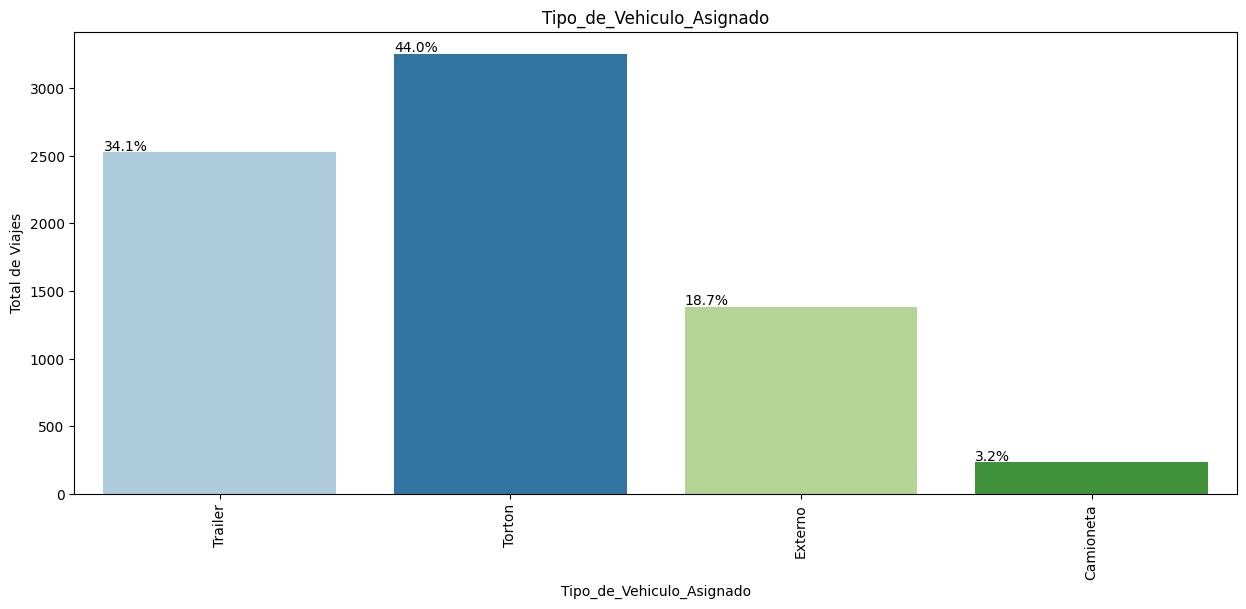

In [134]:
perc_on_bar(df, "Tipo_de_Vehiculo_Asignado")

- Podemos ver que existe una gran similitud en la forma de cada categoría, mostrando que se cubren las necesidades del cliente en la mayoría de los casos.
- La diferencia en el porcentaje de solicitados y asignados cae en la nueva categoría de "Externo", que como se explicaba en secciones anteriores, es el uso de vehículos y conductores de empresas hermanas para cubrir la necesidad del viaje, debido a una falta de capacidad en el negocio.

### ID de las cajas y de los vehículos asignados

<Figure size 3000x1000 with 0 Axes>

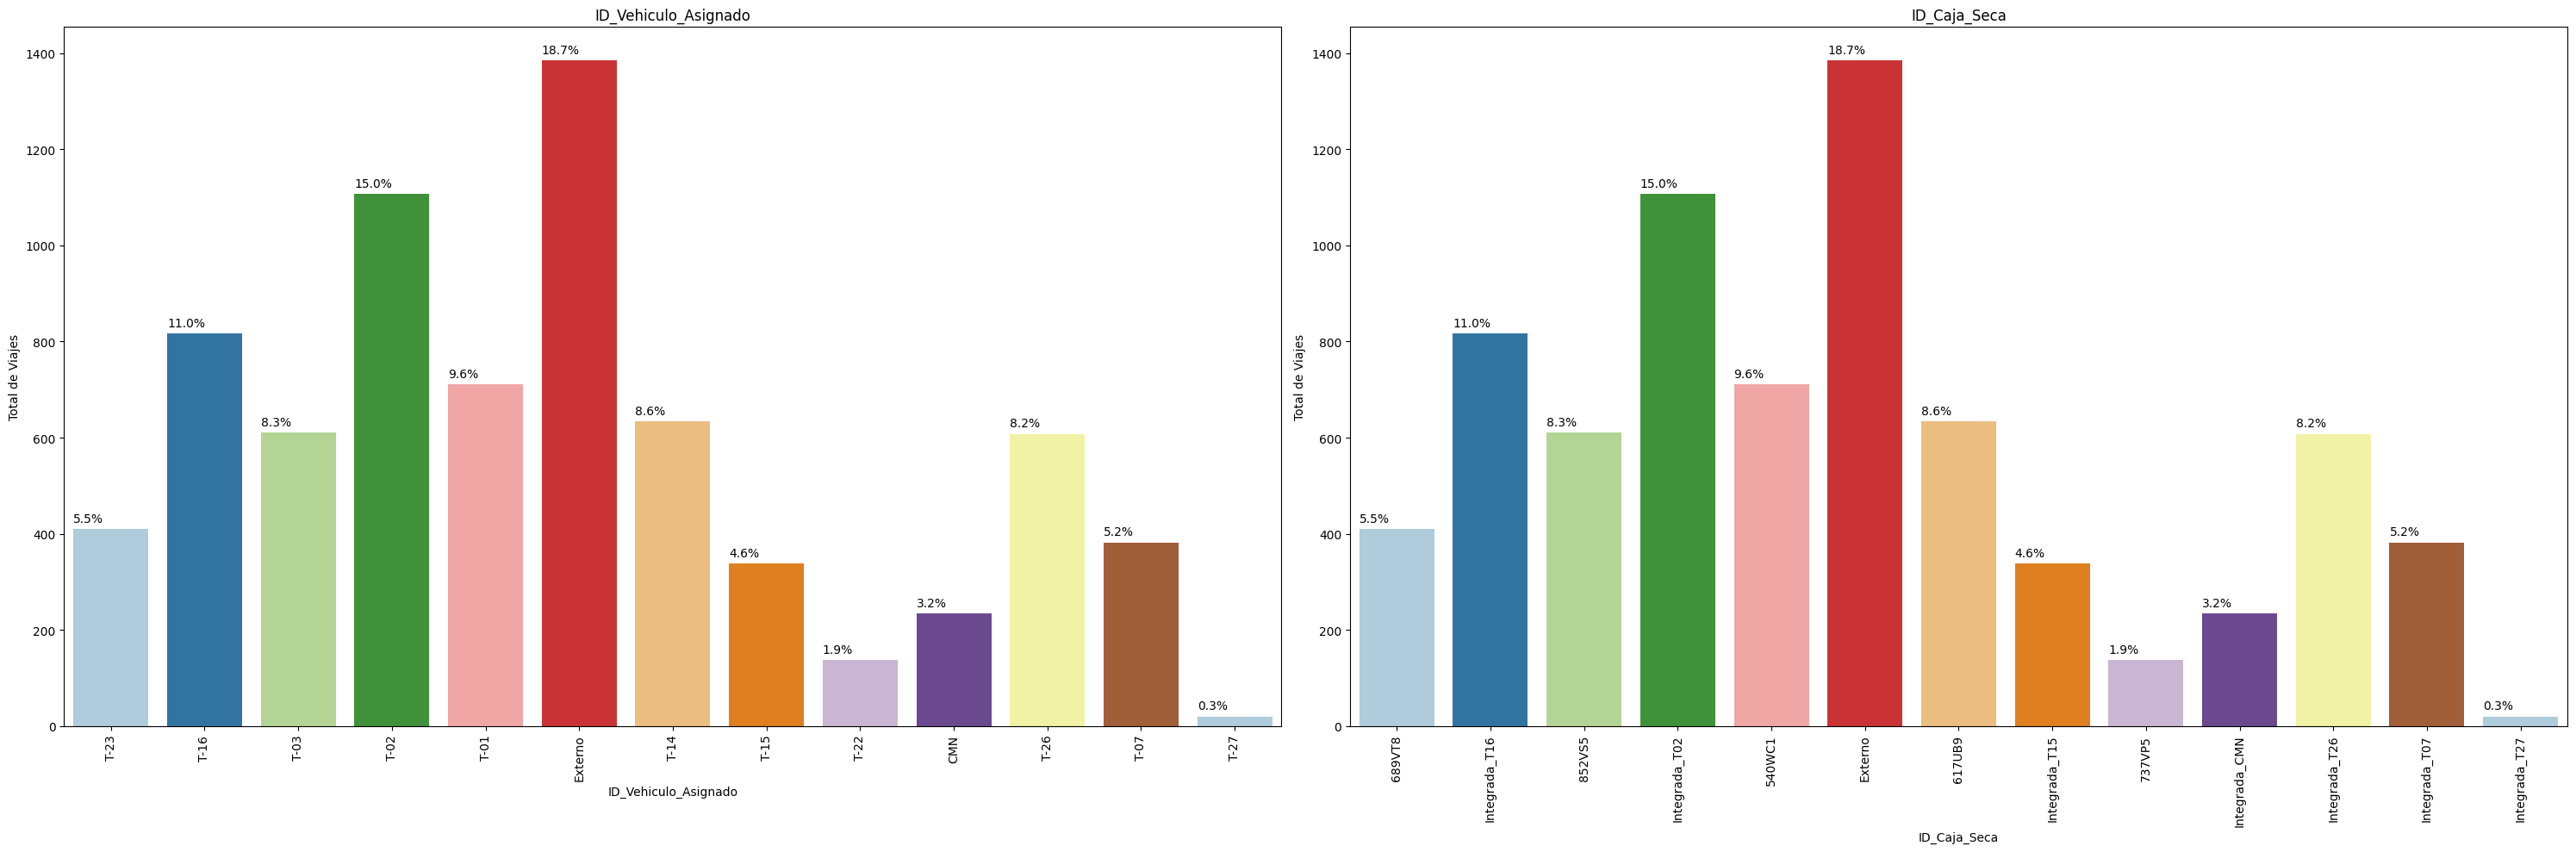

In [135]:
create_grid_of_perc_on_bar(df, ["ID_Vehiculo_Asignado", "ID_Caja_Seca"])

- Podemos ver que son prácticamente idénticos ambos features, por lo que podemos eliminar uno para evitar redundancia y reducir la complejidad del modelo. En este caso removeremos el ID de la caja seca.
- Podemos ver que el vehículo disonible más asignado es el T-02, siendo un Torton Freightliner 1997, con una capacidad de 12 Toneladas
- Igual podemos ver la tendencia de asignar vehículos externos para cubrir la demanda de los clientes

In [136]:
# Removemos la columna con datos identicos
df.drop('ID_Caja_Seca', axis=1, inplace=True)

### Tipo de Cargamento

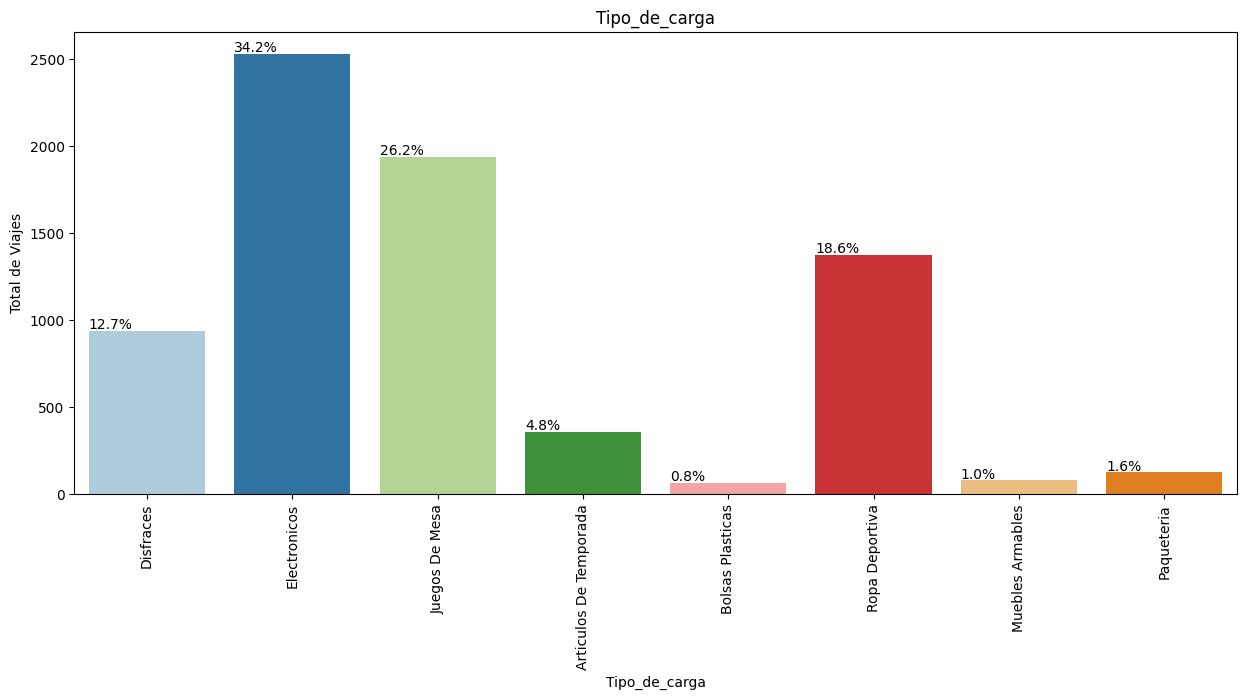

In [137]:
perc_on_bar(df, "Tipo_de_carga")

- El tipo de cargamento con mayor cantidad de viajes son Electrónicos y en segundo lugar son los juegos de mesa

### Tipo de Empaquetado de la Mercancía


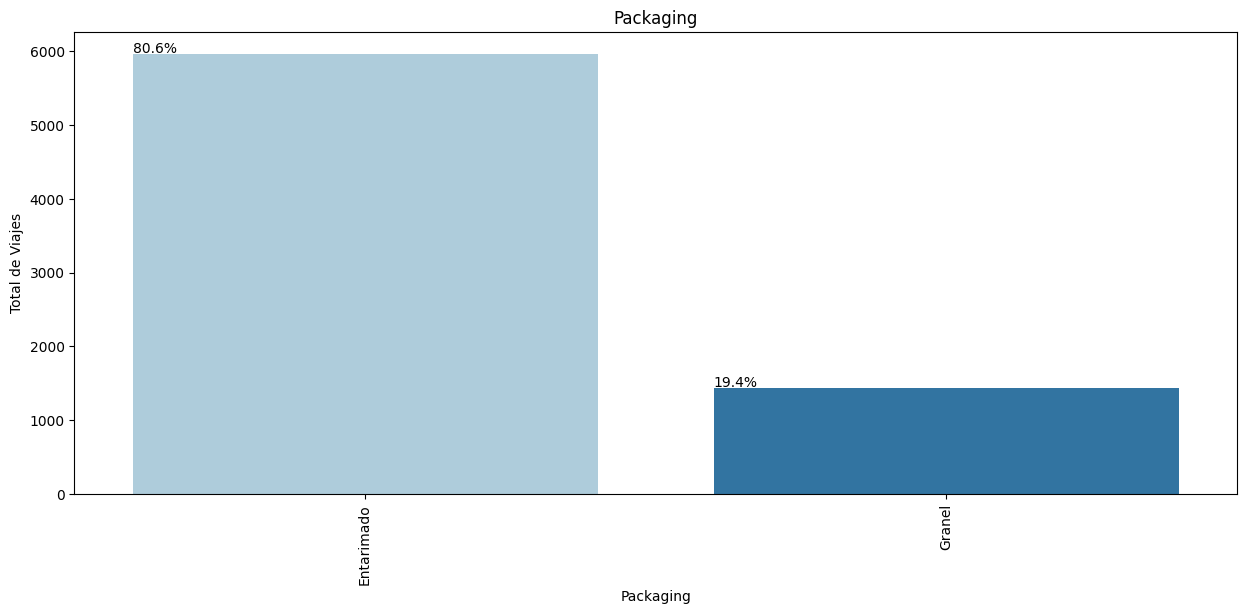

In [138]:
perc_on_bar(df, "Packaging")

- El 80% de sus mercancias son entarimadas, mientras que el 19.4% están a Granel
- Valdría la pena revisar si existe alguna correlación entre el tipo de empaquetado y el status del viaje para descartar que esto pueda ser un factor que afecte la seguridad de la carga

### Status de Orden

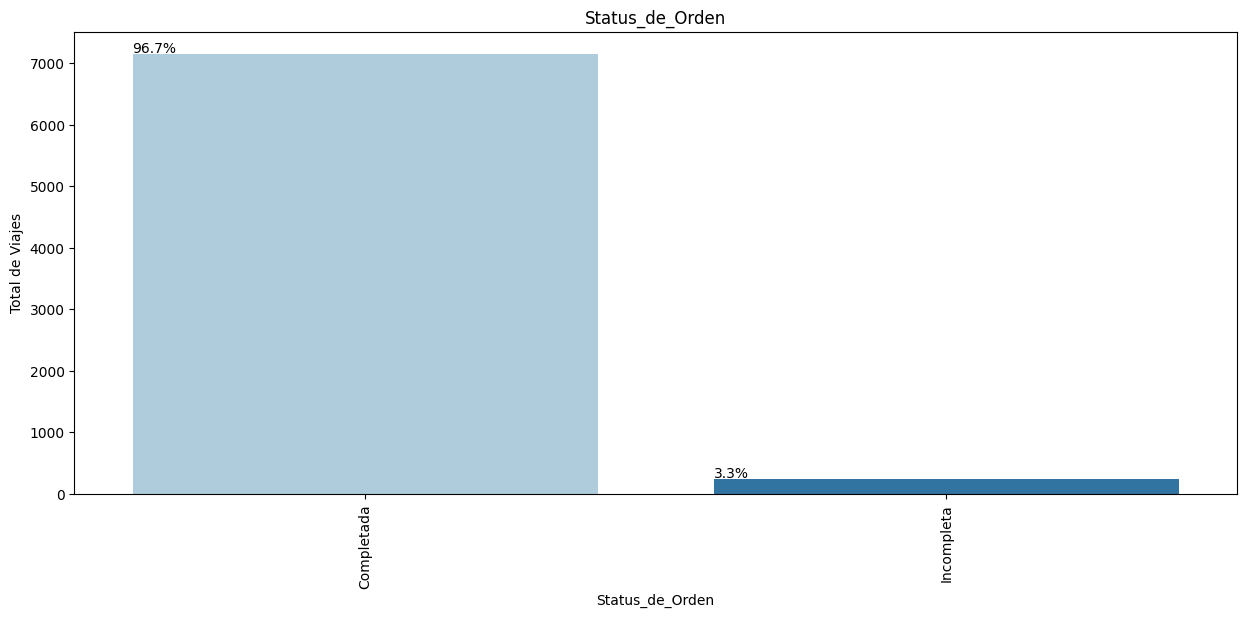

In [139]:
perc_on_bar(df, "Status_de_Orden")

- Podemos ver que TFL cumple con el 96.7% de sus viajes
- Este desbalance del feature podría causar problemas al momento de entrenar el modelo, por lo que se tendrá que balancear la clase para evitar algún sesgo


Ya terminado el análisis univariable podemos proceder al análisis multivariable. En este análisis podemos ver la correlación de los datos, patrones, etc.

## Análisis Multivariable

### Correlación de los datos numéricos

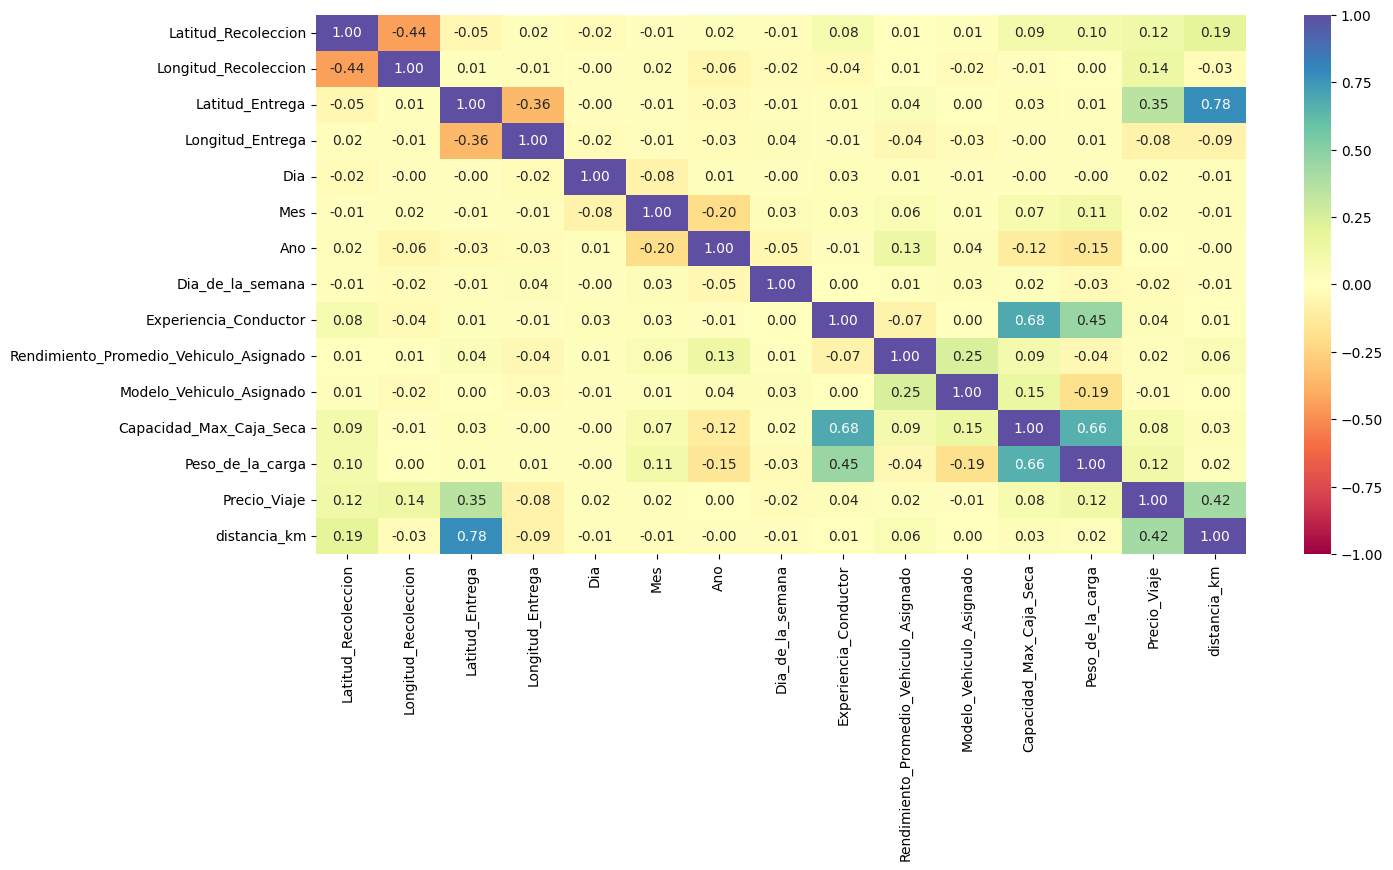

In [140]:
plt.figure(figsize=(15,7))
sns.heatmap(df.select_dtypes(include=['int', 'float']).corr(),annot=True,vmin=-1,vmax=1,fmt='.2f',cmap='Spectral')
plt.show()

- Podemos ver que existe una correlación positiva entre el precio del viaje y la distancia en Km de este. Esto suena lógico porque a más distancia, mayor el consumo de combustible, ergo, costos mas elevados. Sin embargo, esta es medianamente fuerte, por lo que sugiere que no hay una estandarización de precios.
- Existe una correlación fuerte entre la longitud, latitud y la distancia en Km, por lo que podemos precindir de la los longitudes y latitudes para reducir la complejidad del modelo y aún así preservar la información relevante.
- Existe una correlación fuerte entre las cargas más pesadas y los conductores más experimentados. Esto parece ser correcto por la necesidad de un mejor manejo de la unidad y un mejor conocimiento del camino
- De igual manera existe una correlación fuerte entre el peso de la carga y la capacidad de máxima de la carga, lo que suena lógico debido a que dependiendo la carga, se seleccionará que vehículo puede soportar el peso.
- Existe una ligera correlación negativa entre el peso de la carga y el año del vehículo, mostrando que se le asigan los viajes más pesados a las unidades más antiguas, probablemente debido a su capacidad. Esto puede presentar un posible riesgo de fallas durante el trayecto.
- No existe una correlación relevante entre la experiencia del conductor y el rendimiento del combustible.
- Existe una ligera correlación positiva entre el año del vehículo y el rendimiento, mostrando que las unidades más nuevas tienen un rendimiento mejor.

Procedemos a eliminar las variables con correlación muy alta, como lo fue la latitud y longitud, para poder reducir la complejidad del modelo.

In [141]:
# Removemos la columna con datos identicos
df.drop(['Latitud_Recoleccion', 'Longitud_Recoleccion', 'Latitud_Entrega', 'Longitud_Entrega'], axis=1, inplace=True)

## Análisis Multivariable

### Fecha de Viaje vs. Precio del Viaje

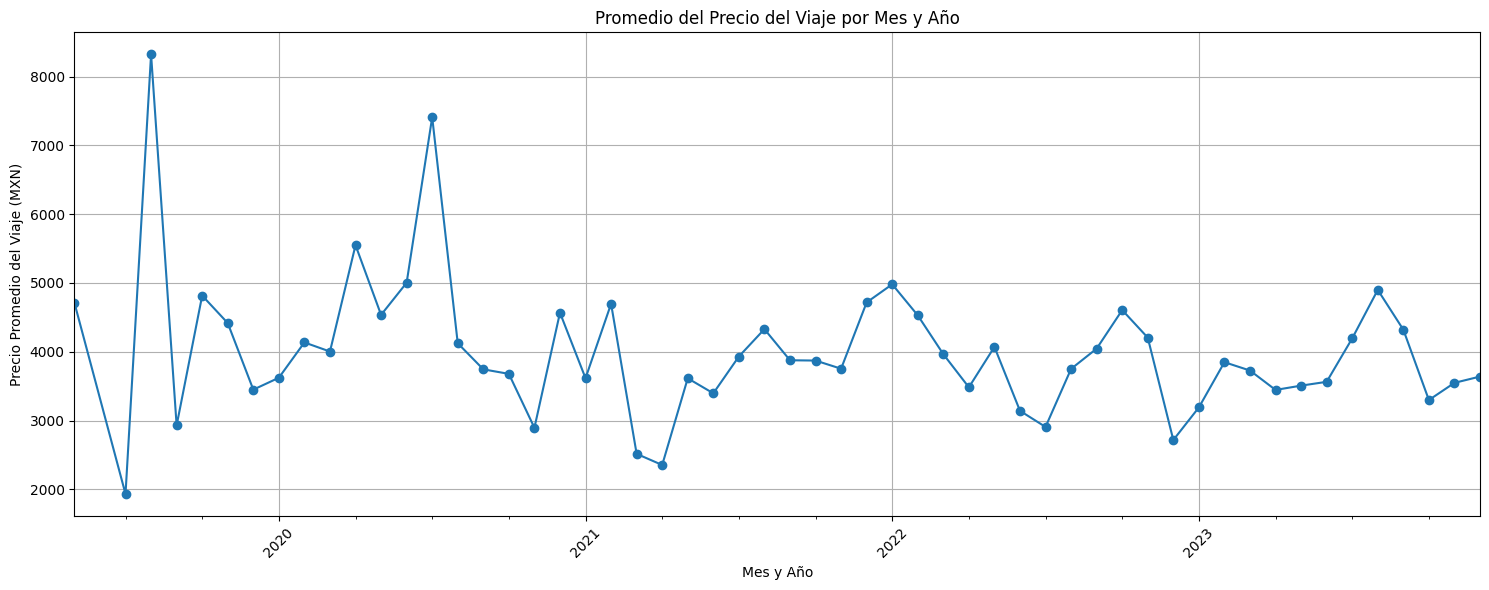

In [142]:
# Primero generamos un dataframe que contenga la variable en conjunto de Fecha
df_fechas = df[["Ano","Mes","Dia","Precio_Viaje"]].copy()
df_fechas['Fecha'] = df_fechas['Ano'].astype(str) + '-' + df_fechas['Mes'].astype(str) + '-' + df_fechas['Dia'].astype(str)
df_fechas['Fecha'] = pd.to_datetime(df_fechas['Fecha'])

# Agrupamos las fechas por mes y año y csacamos el promedio del precio del viaje
df_fechas['Mes y Año'] = df_fechas['Fecha'].dt.to_period('M')

promedio_precios = df_fechas.groupby('Mes y Año')['Precio_Viaje'].mean()

# Mostramos la gráfica
plt.figure(figsize=(15, 6))
promedio_precios.plot(kind='line', marker='o')
plt.title('Promedio del Precio del Viaje por Mes y Año')
plt.xlabel('Mes y Año')
plt.ylabel('Precio Promedio del Viaje (MXN)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

- Podemos ver que los precios más elevados se tuvieron entre el 2019 y 2020, llegando a un promedio entre \$7,500 MXN.
- En los siguientes años se estabilizó entre los \$3,000 y $5,000
- La alza de precios puede significar algún cambio dentro de la empresa o en los clientes. De igual manera la Pandemia pudo haber sido factor.

### Fecha vs. Status de Orden

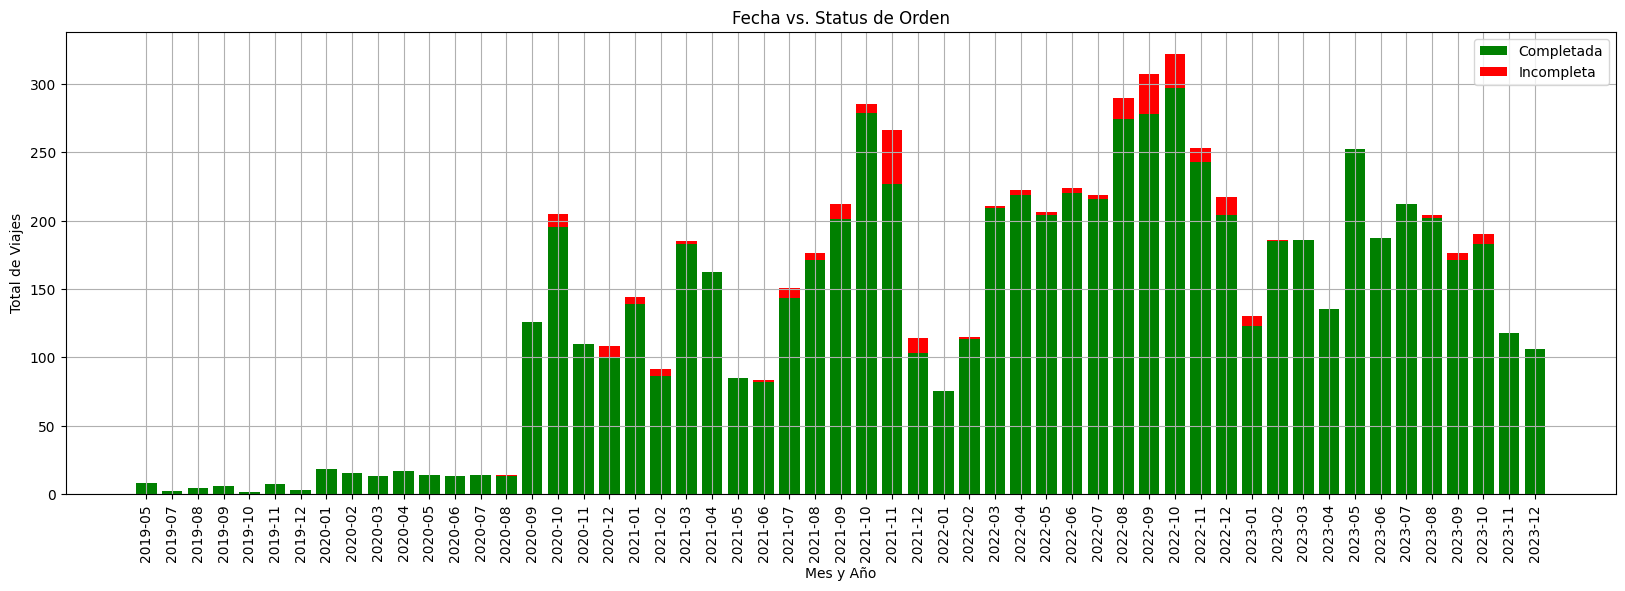

In [143]:
# Primero generamos un dataframe que contenga la variable en conjunto de Fecha
df_fechas = df[["Ano","Mes","Dia","Status_de_Orden"]].copy()
df_fechas['Fecha'] = df_fechas['Ano'].astype(str) + '-' + df_fechas['Mes'].astype(str) + '-' + df_fechas['Dia'].astype(str)
df_fechas['Fecha'] = pd.to_datetime(df_fechas['Fecha'])

# Agrupamos las fechas por mes y año y csacamos el promedio del precio del viaje
df_fechas['Mes y Año'] = df_fechas['Fecha'].dt.to_period('M')

stacked_data = df_fechas.groupby(['Mes y Año', 'Status_de_Orden']).size().unstack(fill_value=0)
stacked_data.index = stacked_data.index.astype(str)
plt.figure(figsize=(20, 6))
plt.bar(stacked_data.index, stacked_data['Completada'], color='g')
plt.bar(stacked_data.index, stacked_data['Incompleta'], bottom=stacked_data['Completada'], color='r')
plt.xlabel("Mes y Año")
plt.ylabel("Total de Viajes")
plt.legend(["Completada", "Incompleta"])
plt.title("Fecha vs. Status de Orden")
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

- Existe un patrón entre el periodo agosto-noviembre y el ratio de ordenes incompletas. Probablemente esto es debido a que es temporada alta para las empresas y hay problemas de logistica.
- Noviembre de 2021 fue el mes con mayor nivel de ordenes incompletas

### Conductor vs. Status de Orden


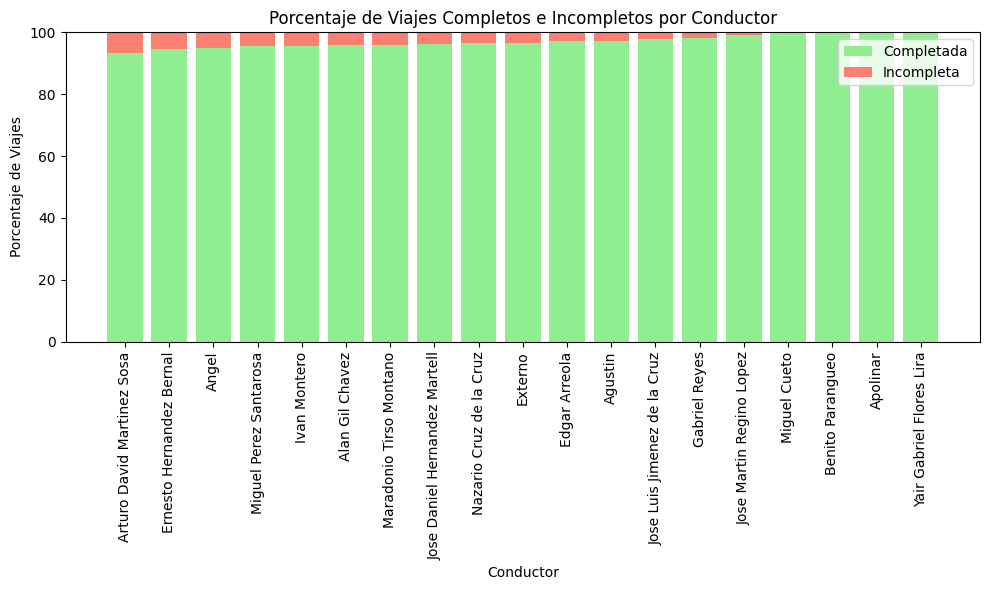

In [144]:
# Calcular el número de viajes completos e incompletos por conductor
viajes_por_conductor = df.groupby('Conductor')['Status_de_Orden'].value_counts().unstack().fillna(0)

# Calcular el porcentaje de viajes completos e incompletos por conductor
viajes_por_conductor['Total'] = viajes_por_conductor.sum(axis=1)
viajes_por_conductor['Porcentaje_Completado'] = viajes_por_conductor['Completada'] / viajes_por_conductor['Total'] * 100
viajes_por_conductor['Porcentaje_Incompleto'] = viajes_por_conductor['Incompleta'] / viajes_por_conductor['Total'] * 100
viajes_por_conductor = viajes_por_conductor.sort_values(by='Porcentaje_Incompleto', ascending=False)


# Graficar
plt.figure(figsize=(10, 6))
plt.bar(viajes_por_conductor.index, viajes_por_conductor['Porcentaje_Completado'], label='Completada', color='lightgreen')
plt.bar(viajes_por_conductor.index, viajes_por_conductor['Porcentaje_Incompleto'], label='Incompleta', bottom=viajes_por_conductor['Porcentaje_Completado'], color='salmon')
plt.xlabel('Conductor')
plt.ylabel('Porcentaje de Viajes')
plt.title('Porcentaje de Viajes Completos e Incompletos por Conductor')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()


###  Conductor vs. Experiencia vs. Status del Conductor

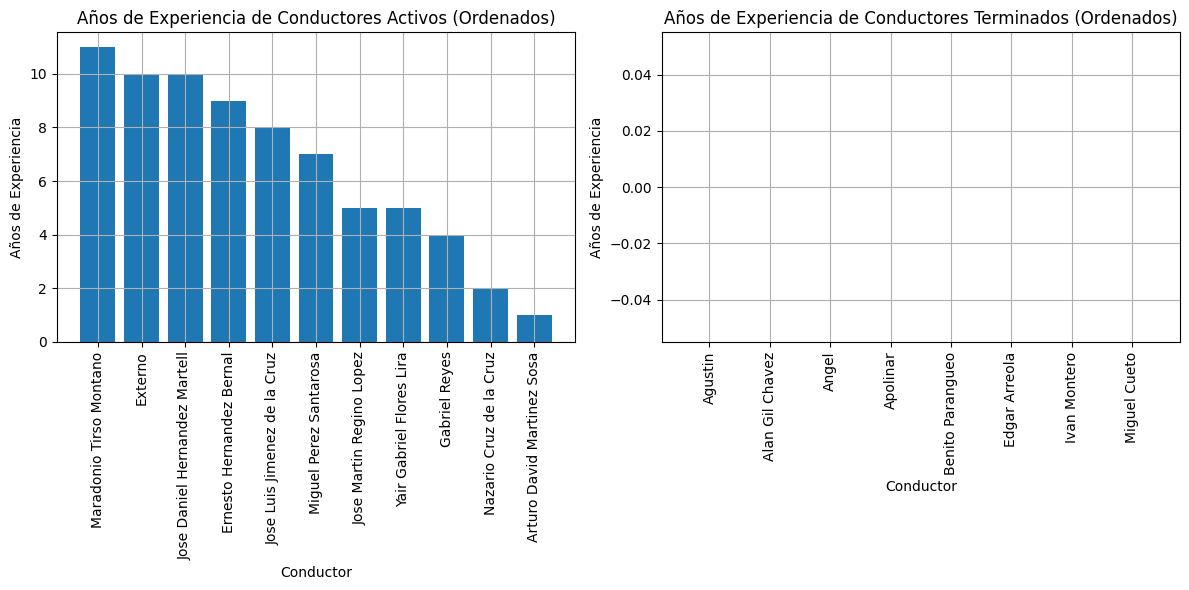

In [145]:
# Filtramos el DataFrame para conductores con estado "Activo" y "Terminado"
df_activo = df[df["Status_Conductor"] == "Activo"].copy()
df_terminado = df[df["Status_Conductor"] == "Terminado"].copy()

# Calculamos los años de experiencia para cada conductor
años_de_experiencia_activo = df_activo.groupby('Conductor')['Experiencia_Conductor'].mean()
años_de_experiencia_terminado = df_terminado.groupby('Conductor')['Experiencia_Conductor'].mean()

# Ordenamos los conductores por años de experiencia de mayor a menor
años_de_experiencia_activo = años_de_experiencia_activo.sort_values(ascending=False)
años_de_experiencia_terminado = años_de_experiencia_terminado.sort_values(ascending=False)

# Creamos una figura con dos subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Graficamos para conductores "Activo"
axs[0].bar(años_de_experiencia_activo.index, años_de_experiencia_activo)
axs[0].set_xlabel('Conductor')
axs[0].set_ylabel('Años de Experiencia')
axs[0].set_title('Años de Experiencia de Conductores Activos (Ordenados)')
axs[0].tick_params(axis='x', rotation=90)
axs[0].grid(True)
# Graficamos para conductores "Terminado"
axs[1].bar(años_de_experiencia_terminado.index, años_de_experiencia_terminado)
axs[1].set_xlabel('Conductor')
axs[1].set_ylabel('Años de Experiencia')
axs[1].set_title('Años de Experiencia de Conductores Terminados (Ordenados)')
axs[1].tick_params(axis='x', rotation=90)
axs[1].grid(True)

# Ajustamos el espacio entre los subplots
plt.tight_layout()

# Mostrar la figura
plt.show()

- Aquí comprobamos la asunción previa de que los conductores terminados tienen 0 años de experiencia en la tabla, esto puede llegar a tomarse como datos nulos. Estos datos podrían ser rellenados tomando en cuenta el primer año que aparecen en los datos como su año de inicio y el último año disponible en sus viajes como su último año.
- Adicional a esto, podemos ver que 8 de sus 10 choferes cuentan con más de 4 años de experiencia por lo que podemos decir que tienen la mayor parte de sus conductores son experimentados.
- Sus choferes más experimentados son Maradonio Tirso y Jose Daniel Hernandez

In [146]:
# Procedemos a calcular los años de experiencia de los choferes terminados con
# base en los datos disponibles en la base de datos

# Agrupamos por conductor y calculamos la diferencia entre el año máximo y mínimo
experiencia_por_conductor = df.groupby('Conductor')['Ano'].apply(lambda x: x.max() - x.min()).reset_index()
experiencia_por_conductor.columns = ['Conductor', 'Experiencia_Calculada']

# Fusionamos el DataFrame original con la experiencia calculada
df = pd.merge(df, experiencia_por_conductor, on='Conductor', how='left')

# Sustituimos los valores de Experiencia_Conductor que son 0 por Experiencia_Calculada
df['Experiencia_Conductor'] = df.apply(lambda row: row['Experiencia_Calculada'] if row['Status_Conductor'] == "Terminado" else row['Experiencia_Conductor'], axis=1)

# Eliminamos la columna Experiencia_Calculada si ya no es necesaria
df.drop('Experiencia_Calculada', axis=1, inplace=True)

Volvemos a graficar los datos

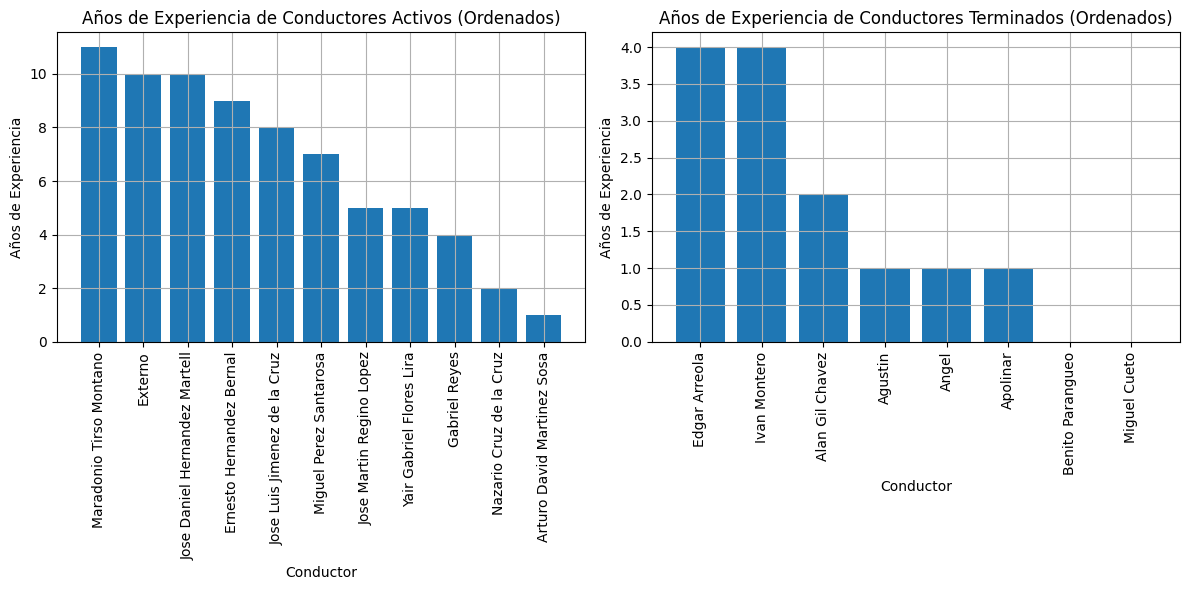

In [147]:
# Filtramos el DataFrame para conductores con estado "Activo" y "Terminado"
df_activo = df[df["Status_Conductor"] == "Activo"].copy()
df_terminado = df[df["Status_Conductor"] == "Terminado"].copy()

# Calculamos los años de experiencia para cada conductor
años_de_experiencia_activo = df_activo.groupby('Conductor')['Experiencia_Conductor'].mean()
años_de_experiencia_terminado = df_terminado.groupby('Conductor')['Experiencia_Conductor'].mean()

# Ordenamos los conductores por años de experiencia de mayor a menor
años_de_experiencia_activo = años_de_experiencia_activo.sort_values(ascending=False)
años_de_experiencia_terminado = años_de_experiencia_terminado.sort_values(ascending=False)

# Creamos una figura con dos subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Graficamos para conductores "Activo"
axs[0].bar(años_de_experiencia_activo.index, años_de_experiencia_activo)
axs[0].set_xlabel('Conductor')
axs[0].set_ylabel('Años de Experiencia')
axs[0].set_title('Años de Experiencia de Conductores Activos (Ordenados)')
axs[0].tick_params(axis='x', rotation=90)
axs[0].grid(True)
# Graficamos para conductores "Terminado"
axs[1].bar(años_de_experiencia_terminado.index, años_de_experiencia_terminado)
axs[1].set_xlabel('Conductor')
axs[1].set_ylabel('Años de Experiencia')
axs[1].set_title('Años de Experiencia de Conductores Terminados (Ordenados)')
axs[1].tick_params(axis='x', rotation=90)
axs[1].grid(True)

# Ajustamos el espacio entre los subplots
plt.tight_layout()

# Mostrar la figura
plt.show()

- Estos datos ya hacen un poco mas de sentido. Edgar Arreola e Ivan Montero teóricamente son conductores con más experiencia que han despedido.

### Conductor vs. ID del Vehiculo Asignado

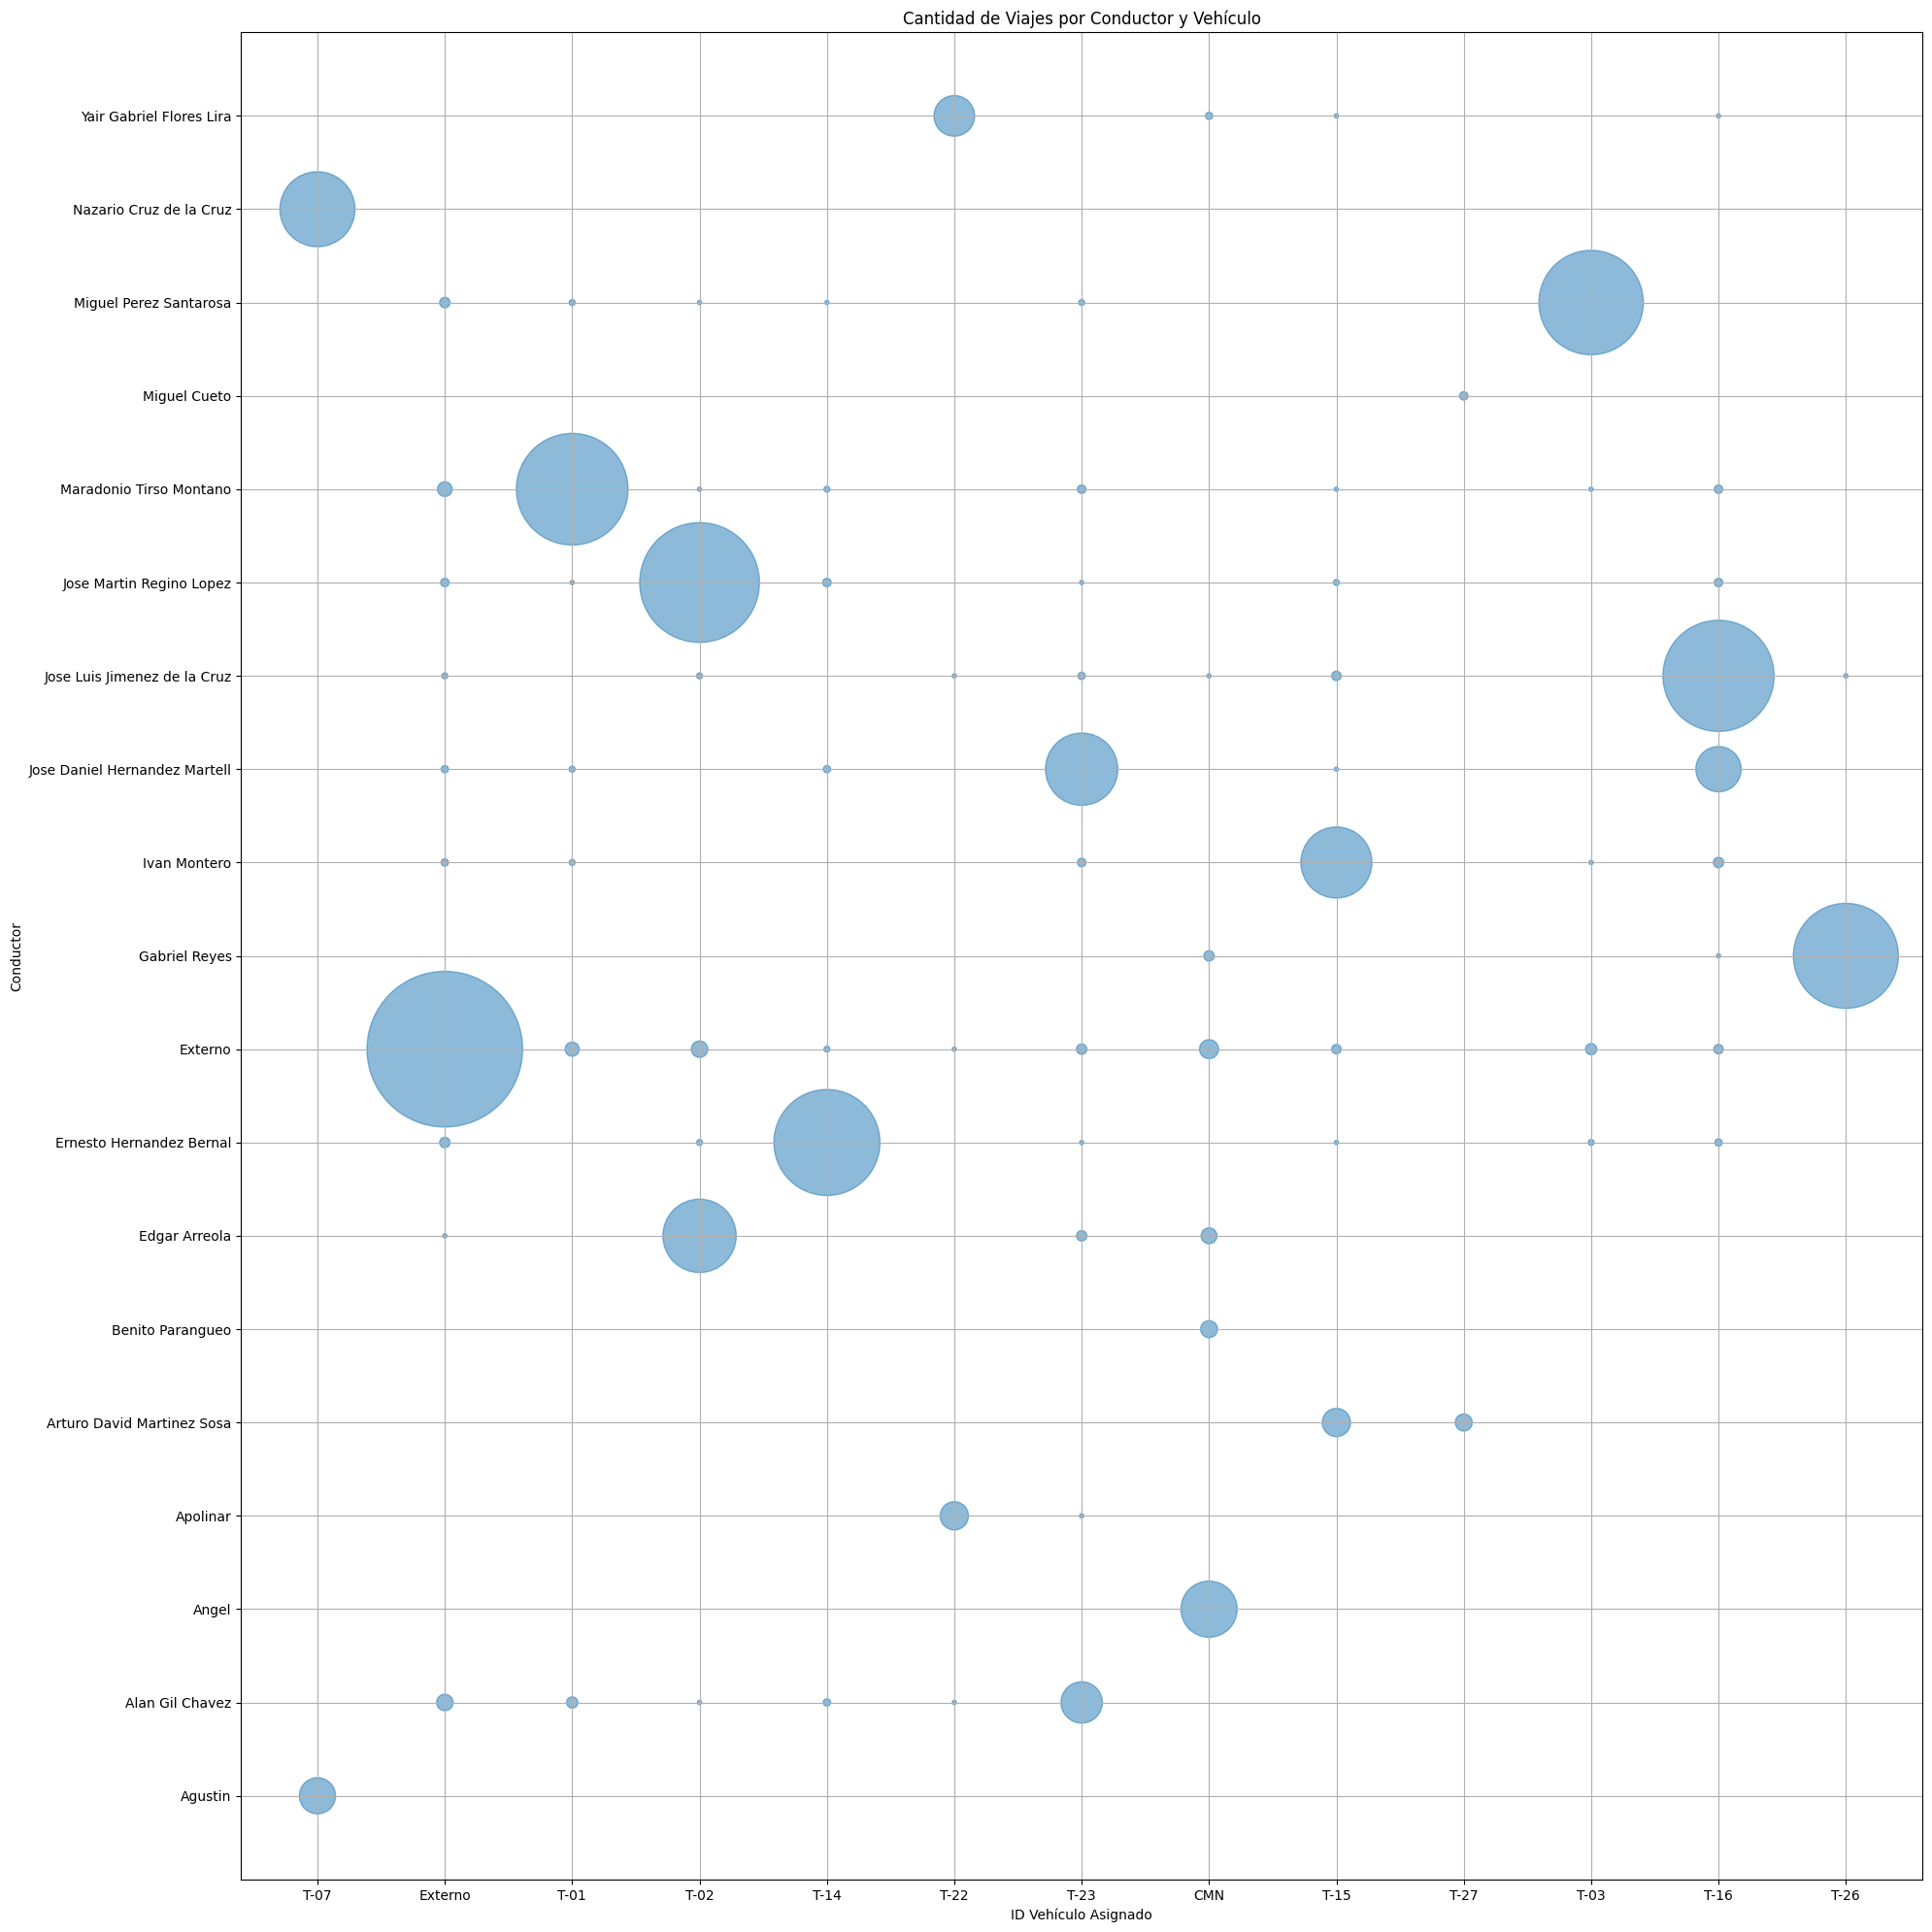

In [148]:
# Contar cuántas veces aparece cada combinación de conductor y vehículo asignado
conteo_conductor_vehiculo = df.groupby(['Conductor', 'ID_Vehiculo_Asignado']).size().reset_index(name='Count')

# Graficar
plt.figure(figsize=(20, 20))
plt.grid(True)
plt.scatter(conteo_conductor_vehiculo['ID_Vehiculo_Asignado'], conteo_conductor_vehiculo['Conductor'], s=conteo_conductor_vehiculo['Count']*10, alpha=0.5)
plt.xlabel('ID Vehículo Asignado')
plt.ylabel('Conductor')
plt.title('Cantidad de Viajes por Conductor y Vehículo')
plt.tight_layout()
plt.show()

- Esta gráfica es bastante interesante porque nos permite ver la concentración de viajes por cada combinación.
- Aquí podemos ver que incluso conductores locales han utilizado vehículos externos y viceversa, conductores externos han usado vehículos locales.
- Las combinaciones más prominentes son:
  * Jose Martin Regino Lopez con el vehículo T-02
  * Maradonio Tirso Montano con el vehículo T-01
  * Miguel Perez Santarosa con el vehículo T-03
  * Jose Luis Jimenez con el T-16
  * Gabriel Reyes con el T-26


### Conductor vs Rendimiento Promedio del Vehículo Asignado

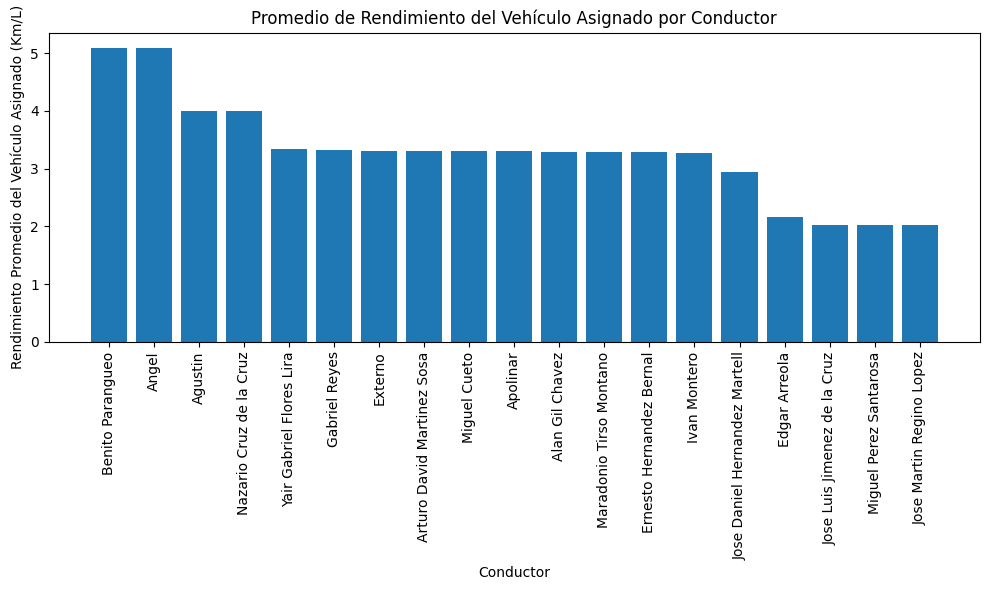

In [149]:
# Agrupar por conductor y calcular el promedio de los rendimientos promedio de los vehículos asignados
rendimiento_promedio_por_conductor = df.groupby('Conductor')['Rendimiento_Promedio_Vehiculo_Asignado'].mean()
rendimiento_promedio_por_conductor = rendimiento_promedio_por_conductor.sort_values(ascending=False)
# Graficar
plt.figure(figsize=(10, 6))
plt.bar(rendimiento_promedio_por_conductor.index, rendimiento_promedio_por_conductor)
plt.xlabel('Conductor')
plt.ylabel('Rendimiento Promedio del Vehículo Asignado (Km/L)')
plt.title('Promedio de Rendimiento del Vehículo Asignado por Conductor')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


- Podemos ver que los conductores con mayor rendimiento son Benito Parangueo, Angel, Agustin y Nazario
-  El promedio esta alrededor de los 3Km/L
- Los conductores con menor rendimiento promedio son Jose Luis Jimenez, Miguel Perez Santarosa y Jose Martin Regino

### Conductor vs. Precio del Viaje

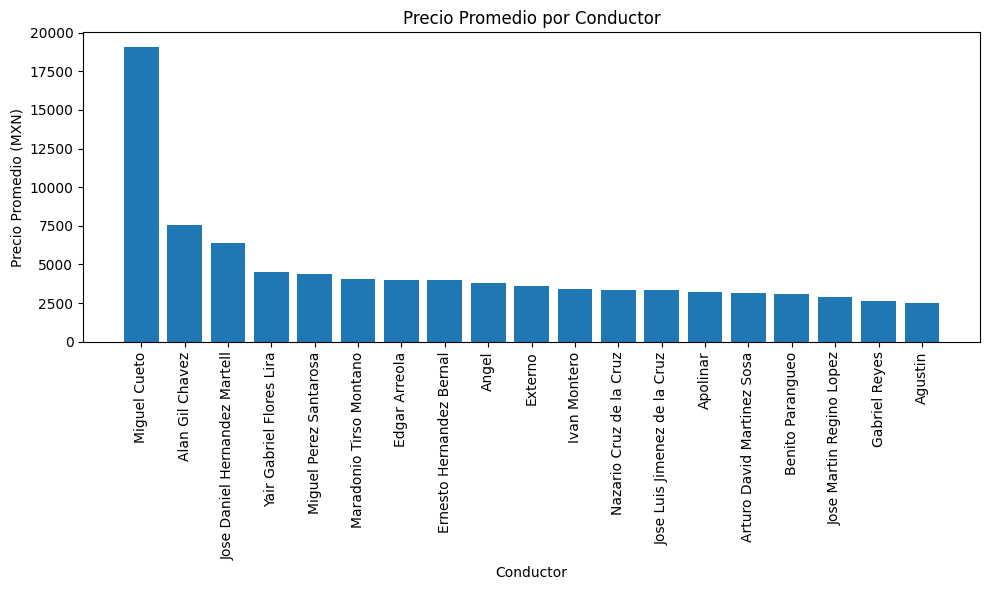

In [150]:
# Agrupar por conductor y calcular el promedio de los Precios Promedio de
# los viajes
precio_promedio_por_conductor = df.groupby('Conductor')['Precio_Viaje'].mean()
precio_promedio_por_conductor = precio_promedio_por_conductor.sort_values(ascending=False)
# Graficar
plt.figure(figsize=(10, 6))
plt.bar(precio_promedio_por_conductor.index, precio_promedio_por_conductor)
plt.xlabel('Conductor')
plt.ylabel('Precio Promedio (MXN)')
plt.title('Precio Promedio por Conductor')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

- Miguel Cueto por mucho se ha llevado los viajes más caros (más de \$17,500 en promedio)
- El resto de los conductores están dentro del rango de entre \$7,500 y \$2,500 en promedio.

### Conductor vs. Peso de la Carga vs. Tipo de Vehiculo Asignado

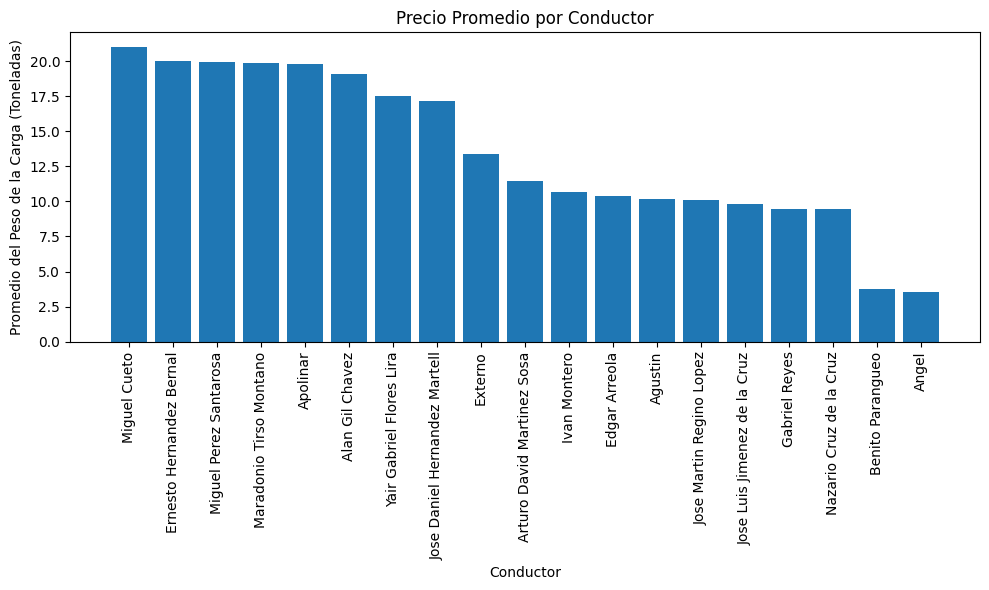

In [151]:
# Agrupar por conductor y calcular el promedio del peso de la carga
Peso_de_la_carga_por_conductor = df.groupby('Conductor')['Peso_de_la_carga'].mean()
Peso_de_la_carga_por_conductor = Peso_de_la_carga_por_conductor.sort_values(ascending=False)
# Graficar
plt.figure(figsize=(10, 6))
plt.bar(Peso_de_la_carga_por_conductor.index, Peso_de_la_carga_por_conductor)
plt.xlabel('Conductor')
plt.ylabel('Promedio del Peso de la Carga (Toneladas)')
plt.title('Precio Promedio por Conductor')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

- Miguel Cueto, Ernesto Hernandez, Miguel Perez Satnarosa, Maradonio Tirso, Apolinar y Alan Gil Chavez son los coductores que mayor peso manejan en promedio en sus viajes.
- Angel y Benito Parangueo son los que menos peso cargan en sus viajes

### Cliente vs. Precio del Viaje

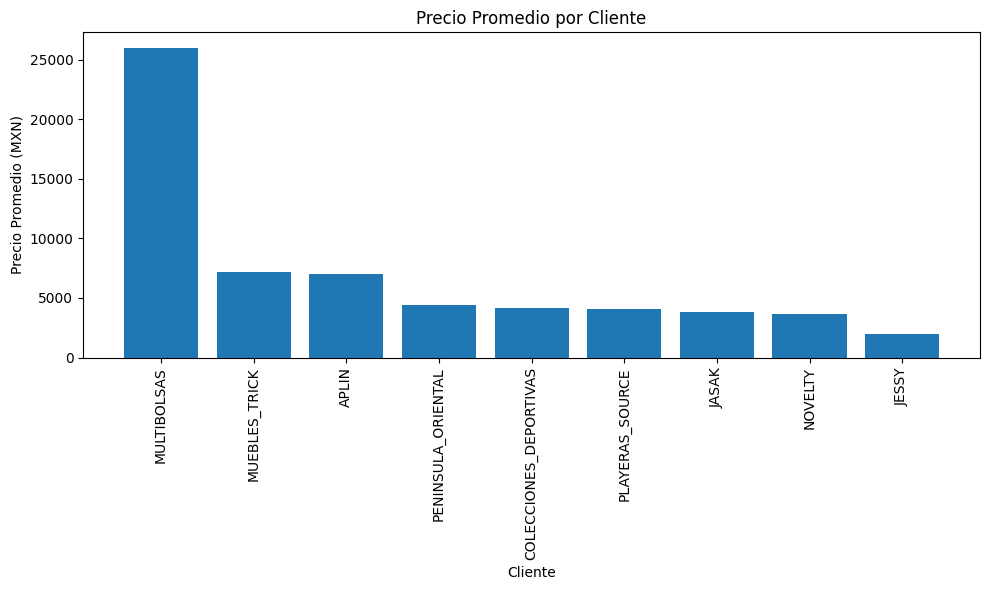

In [152]:
# Agrupar por cliente y calcular el promedio de los Precios Promedio de
# los viajes
precio_promedio_por_cliente = df.groupby('Cliente')['Precio_Viaje'].mean()
precio_promedio_por_cliente = precio_promedio_por_cliente.sort_values(ascending=False)
# Graficar
plt.figure(figsize=(10, 6))
plt.bar(precio_promedio_por_cliente.index, precio_promedio_por_cliente)
plt.xlabel('Cliente')
plt.ylabel('Precio Promedio (MXN)')
plt.title('Precio Promedio por Cliente')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

- Multibolsas tiene en promedio el precio más elevado por mucha diferencia con el resto de los clientes (arriba de \$25,000)
- Jessy es el cliente con menor precio (Debajo de los \$2,500)

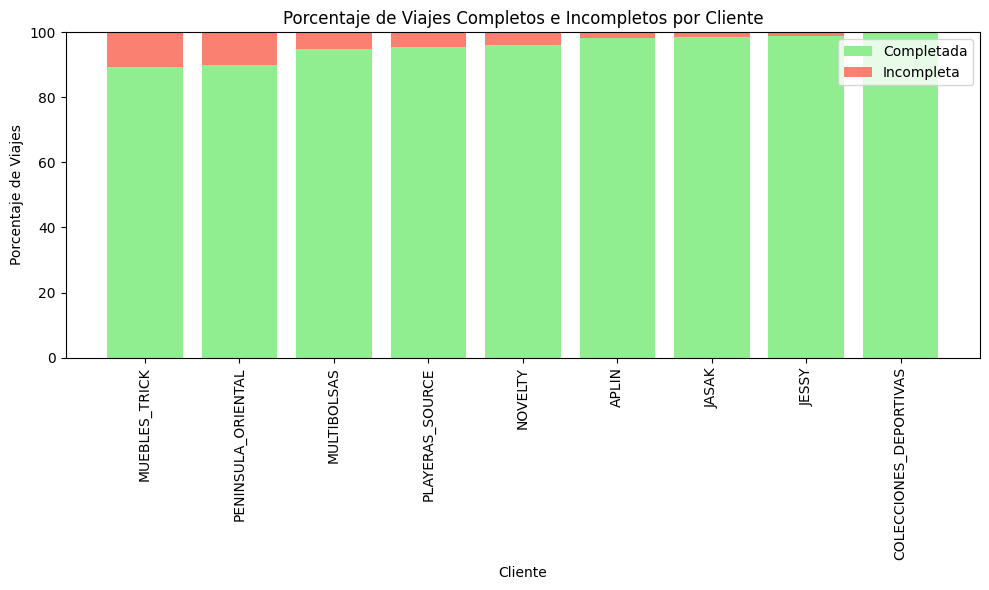

In [153]:
# Calcular el número de viajes completos e incompletos por conductor
viajes_por_cliente = df.groupby('Cliente')['Status_de_Orden'].value_counts().unstack().fillna(0)

# Calcular el porcentaje de viajes completos e incompletos por conductor
viajes_por_cliente['Total'] = viajes_por_cliente.sum(axis=1)
viajes_por_cliente['Porcentaje_Completado'] = viajes_por_cliente['Completada'] / viajes_por_cliente['Total'] * 100
viajes_por_cliente['Porcentaje_Incompleto'] = viajes_por_cliente['Incompleta'] / viajes_por_cliente['Total'] * 100
viajes_por_cliente = viajes_por_cliente.sort_values(by='Porcentaje_Incompleto', ascending=False)


# Graficar
plt.figure(figsize=(10, 6))
plt.bar(viajes_por_cliente.index, viajes_por_cliente['Porcentaje_Completado'], label='Completada', color='lightgreen')
plt.bar(viajes_por_cliente.index, viajes_por_cliente['Porcentaje_Incompleto'], label='Incompleta', bottom=viajes_por_cliente['Porcentaje_Completado'], color='salmon')
plt.xlabel('Cliente')
plt.ylabel('Porcentaje de Viajes')
plt.title('Porcentaje de Viajes Completos e Incompletos por Cliente')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()


- Muebles Trick tiene el porcentaje más bajo de entregas completadas, con un 90% de viajes completados aproximadamente. Aún así es un buen porcentaje de viajes completados.
- Colecciones deportivas es el único cliente con el 100% de sus viajes completados

### Cliente vs. Conductor

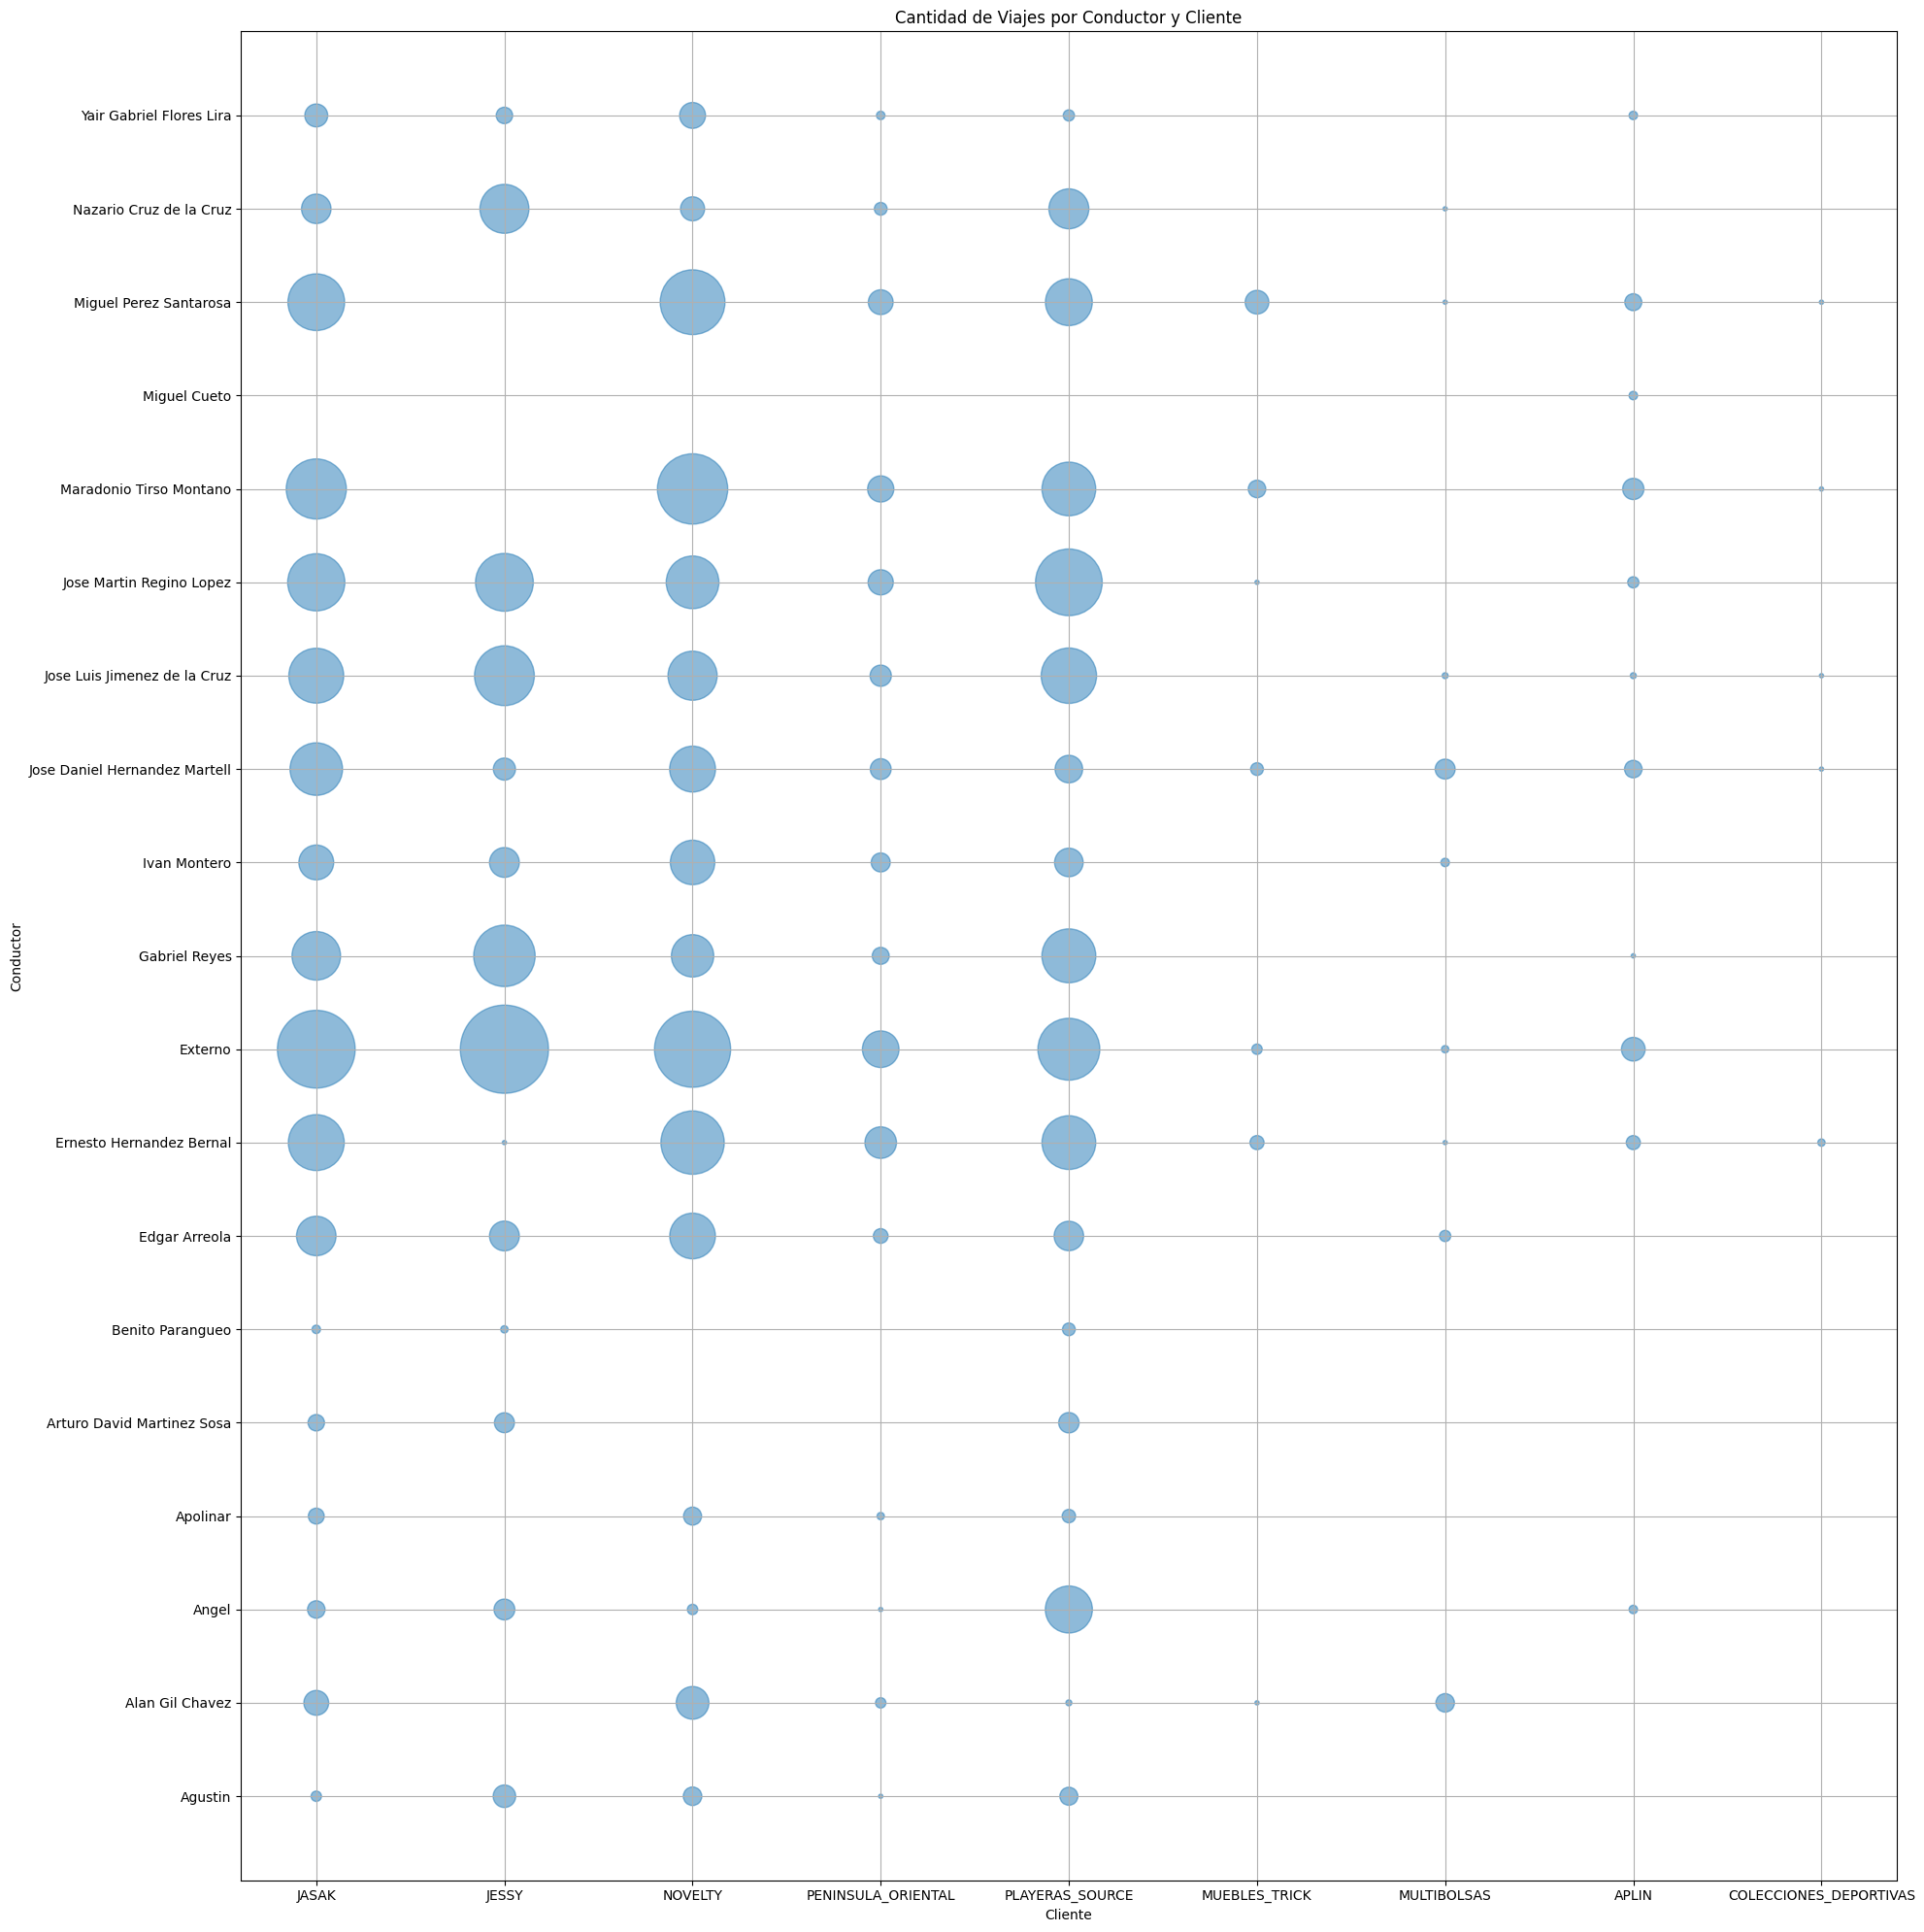

In [154]:
# Contar cuántas veces aparece cada combinación de conductor y cliente
conteo_conductor_cliente = df.groupby(['Conductor', 'Cliente']).size().reset_index(name='Count')

# Graficar
plt.figure(figsize=(20, 20))
plt.grid(True)
plt.scatter(conteo_conductor_cliente['Cliente'], conteo_conductor_cliente['Conductor'], s=conteo_conductor_cliente['Count']*10, alpha=0.5)
plt.xlabel('Cliente')
plt.ylabel('Conductor')
plt.title('Cantidad de Viajes por Conductor y Cliente')
plt.tight_layout()
plt.show()

- Podemos ver que no existe una correlación fuerte entre clientes y conductores
- La correlación más fuerte es de los conductores externos y los clientes Jessy y Novelty
- Los clientes que tienen menor concentración podría ser porque son clientes relativamente nuevos

### Vehículo Asignado vs. Cliente

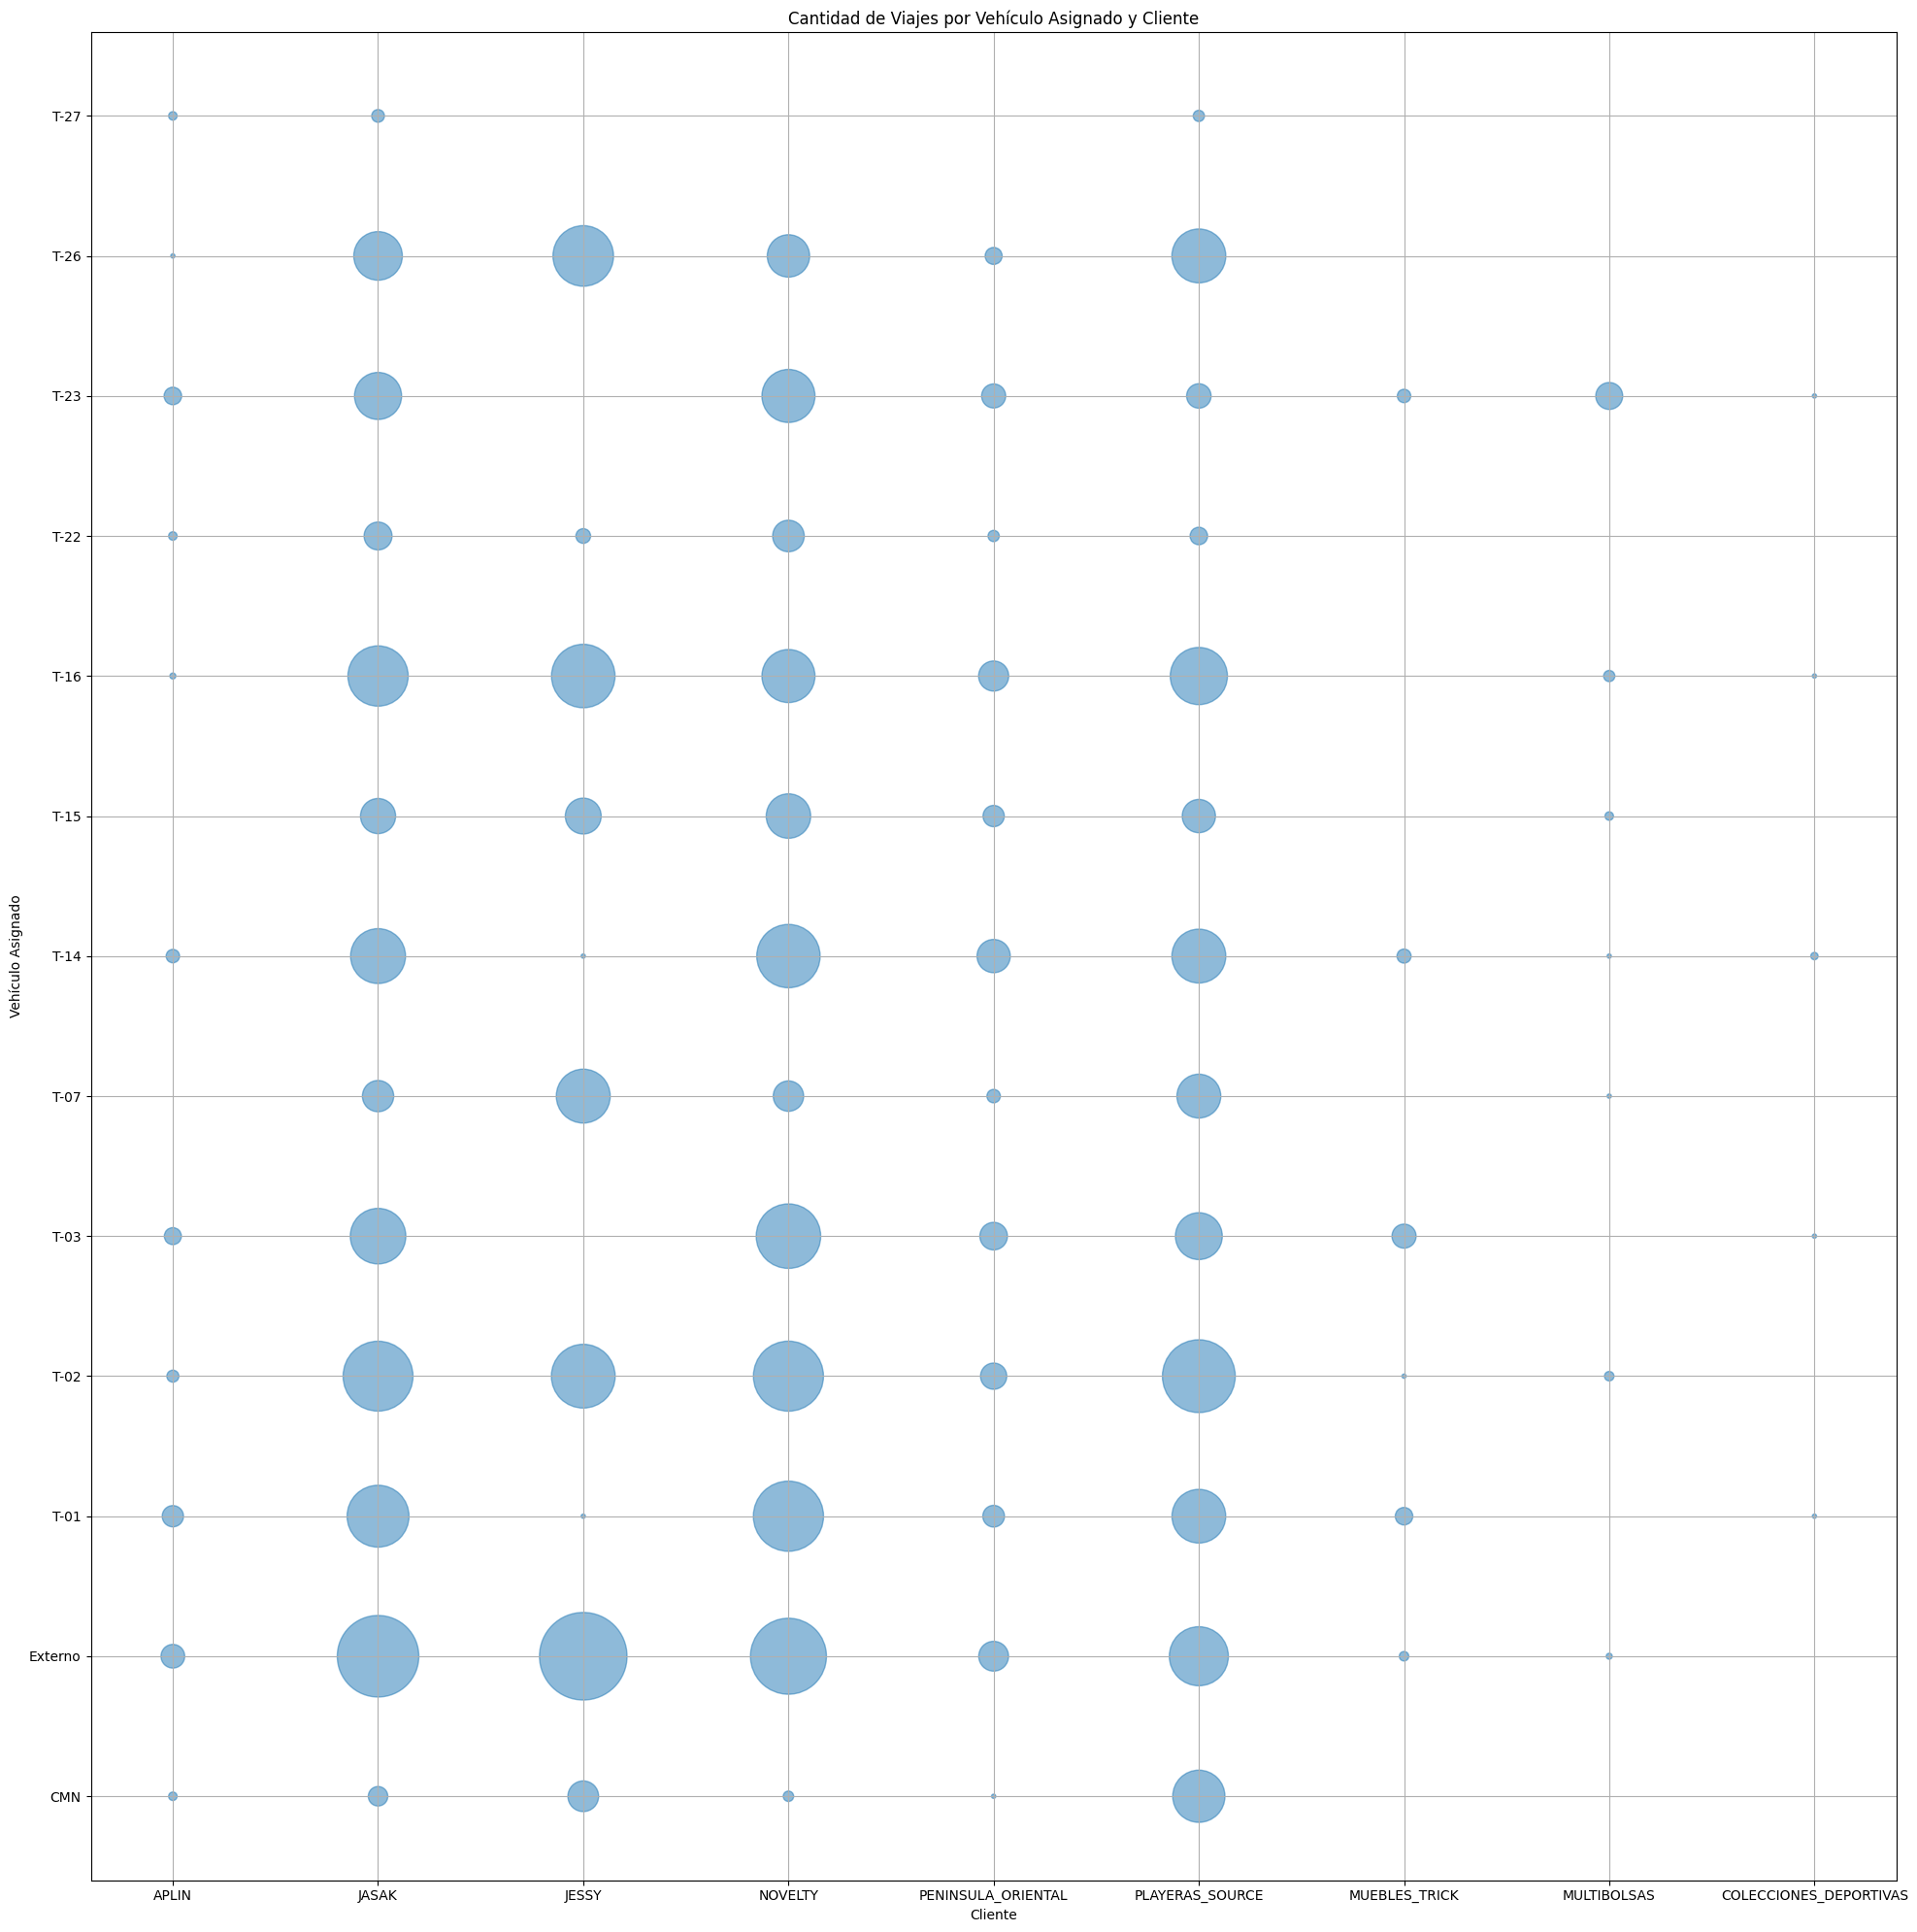

In [155]:
# Contar cuántas veces aparece cada combinación de conductor y cliente
conteo_vehiculo_cliente = df.groupby(['ID_Vehiculo_Asignado', 'Cliente']).size().reset_index(name='Count')

# Graficar
plt.figure(figsize=(20, 20))
plt.grid(True)
plt.scatter(conteo_vehiculo_cliente['Cliente'], conteo_vehiculo_cliente['ID_Vehiculo_Asignado'], s=conteo_vehiculo_cliente['Count']*10, alpha=0.5)
plt.xlabel('Cliente')
plt.ylabel('Vehículo Asignado')
plt.title('Cantidad de Viajes por Vehículo Asignado y Cliente')
plt.tight_layout()
plt.show()

- Existe una concentración de los clientes Jasak, Jessy, Novelty y Playeras Source con las unidades T-03, T-02, T-01 y Vehículos Externos

### Rendimiento Promedio por Vehículo


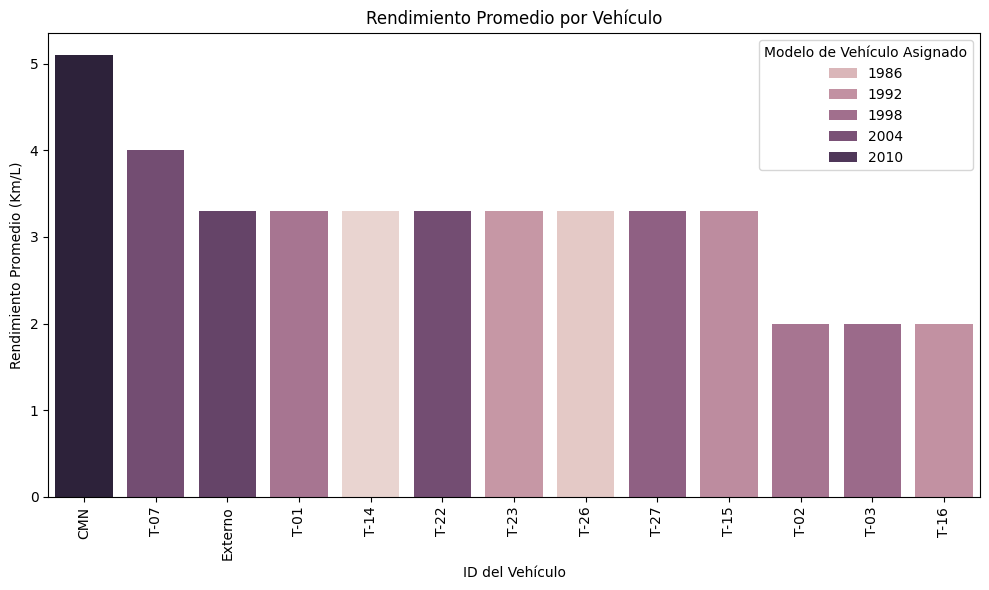

In [156]:
# Agrupar por vehículo y calcular el rendimiento promedio por vehículo
rendimiento_por_vehiculo = df.groupby('ID_Vehiculo_Asignado')['Rendimiento_Promedio_Vehiculo_Asignado'].mean()
rendimiento_por_vehiculo = rendimiento_por_vehiculo.sort_values(ascending=False)

# Fusionar los datos de rendimiento por vehículo con los datos de modelo de vehículo
df_rendimiento_modelo = pd.merge(rendimiento_por_vehiculo, df[['ID_Vehiculo_Asignado', 'Modelo_Vehiculo_Asignado']], on='ID_Vehiculo_Asignado', how='left')

# Crear el gráfico
plt.figure(figsize=(10, 6))
sns.barplot(x='ID_Vehiculo_Asignado', y='Rendimiento_Promedio_Vehiculo_Asignado', hue='Modelo_Vehiculo_Asignado', data=df_rendimiento_modelo)
plt.xlabel('ID del Vehículo')
plt.ylabel('Rendimiento Promedio (Km/L)')
plt.title('Rendimiento Promedio por Vehículo')
plt.xticks(rotation=90)
plt.legend(title='Modelo de Vehículo Asignado')
plt.tight_layout()
plt.show()


- La camioneta CMN es el vehículo con mayor rendimiento (5km/L), siendo el vehículo más nuevo
- El T-16 es el vehículo con menor rendimiento (2km/L), siendo uno de los vehículos más viejos de la flotilla.

### Vehículo Asignado vs. Status de Orden

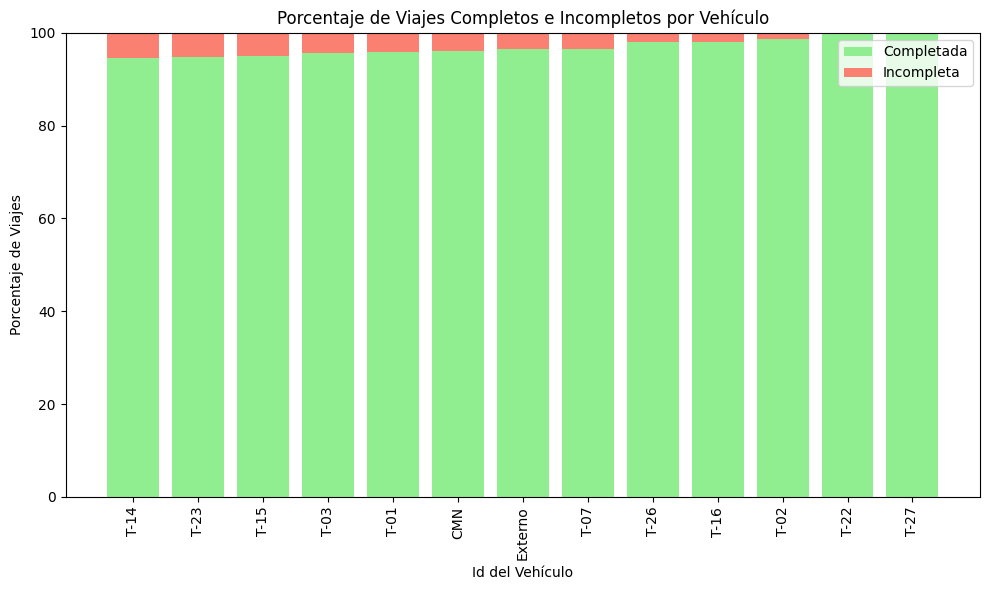

In [157]:
# Calcular el número de viajes completos e incompletos por conductor
viajes_por_vehiculo = df.groupby('ID_Vehiculo_Asignado')['Status_de_Orden'].value_counts().unstack().fillna(0)

# Calcular el porcentaje de viajes completos e incompletos por conductor
viajes_por_vehiculo['Total'] = viajes_por_vehiculo.sum(axis=1)
viajes_por_vehiculo['Porcentaje_Completado'] = viajes_por_vehiculo['Completada'] / viajes_por_vehiculo['Total'] * 100
viajes_por_vehiculo['Porcentaje_Incompleto'] = viajes_por_vehiculo['Incompleta'] / viajes_por_vehiculo['Total'] * 100
viajes_por_vehiculo = viajes_por_vehiculo.sort_values(by='Porcentaje_Incompleto', ascending=False)


# Graficar
plt.figure(figsize=(10, 6))
plt.bar(viajes_por_vehiculo.index, viajes_por_vehiculo['Porcentaje_Completado'], label='Completada', color='lightgreen')
plt.bar(viajes_por_vehiculo.index, viajes_por_vehiculo['Porcentaje_Incompleto'], label='Incompleta', bottom=viajes_por_vehiculo['Porcentaje_Completado'], color='salmon')
plt.xlabel('Id del Vehículo')
plt.ylabel('Porcentaje de Viajes')
plt.title('Porcentaje de Viajes Completos e Incompletos por Vehículo')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

- El T-14 es el vehículo con el menor porcentaje de viajes completados. El T-14 es uno de los modelos más viejos de los vehículos de la flotilla, siendo de 1986. Podría existir una correlación entre su antigüedad y su porcentaje bajo de viajes completos.
- El T-22 y el T-27 tienen un 100% de viajes completados

### Tipo de Vehículo Solicitado vs Tipo de Vehículo Asignado

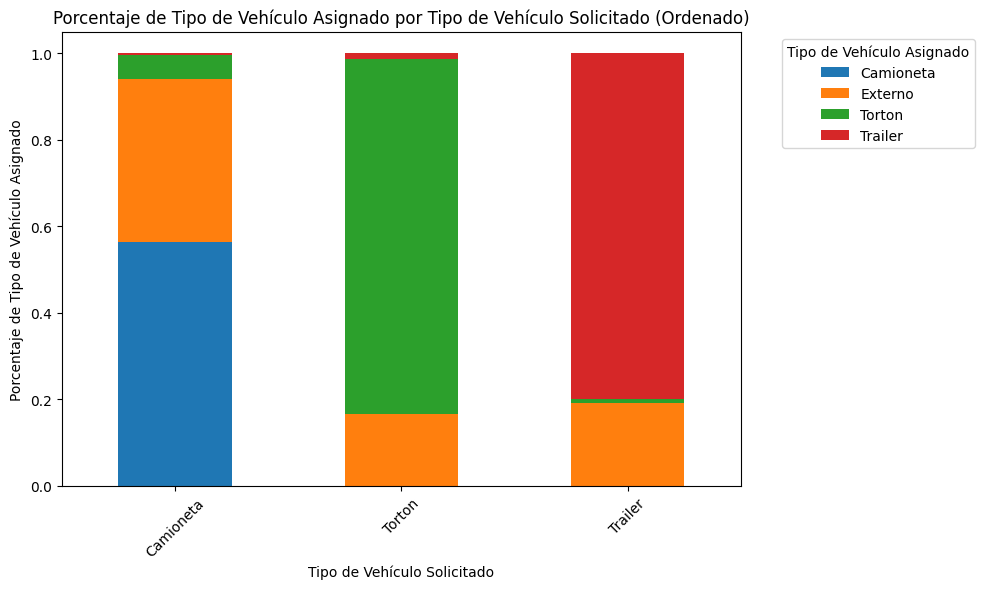

In [158]:
# Calcular el número de ocurrencias de cada combinación de tipo de vehículo solicitado y tipo de vehículo asignado
conteo_combinaciones = df.groupby(['Tipo_de_Vehiculo_Solicitado', 'Tipo_de_Vehiculo_Asignado']).size().unstack(fill_value=0)

# Calcular el porcentaje de cada tipo de vehículo asignado para cada tipo de vehículo solicitado
porcentaje_por_tipo_solicitado = conteo_combinaciones.apply(lambda row: row / row.sum(), axis=1)

# Ordenar las columnas de cada fila de mayor a menor porcentaje
porcentaje_por_tipo_solicitado = porcentaje_por_tipo_solicitado.apply(lambda x: x.sort_values(ascending=False), axis=1)

# Graficar
porcentaje_por_tipo_solicitado.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.xlabel('Tipo de Vehículo Solicitado')
plt.ylabel('Porcentaje de Tipo de Vehículo Asignado')
plt.title('Porcentaje de Tipo de Vehículo Asignado por Tipo de Vehículo Solicitado (Ordenado)')
plt.xticks(rotation=45)
plt.legend(title='Tipo de Vehículo Asignado', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

- Podemos ver que el vehiculo solicitado con menor disponibilidad es la camioneta. Casi un 30% de las veces que se solicita, se manda a un externo. Sólo el 55% de las ocasiones se manda lo que se solicitó.
- Seguimos viendo un porcentaje alto de solicitudes que se mandan a vehículos externos. Esto reafirma la necesidad del negocio por crecer su flotilla o administrar diferentes sus recursos.

### Peso de la Carga vs. Precio del Viaje

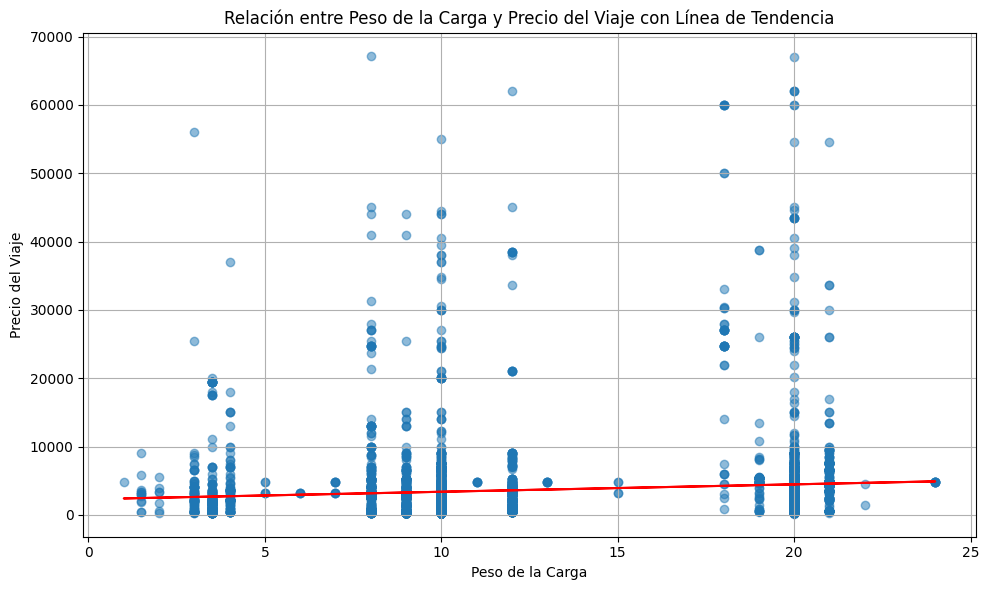

In [159]:
# Calcular la pendiente (m) e intersección (b) de la línea de tendencia
m, b = np.polyfit(df['Peso_de_la_carga'], df['Precio_Viaje'], 1)

# Graficar el diagrama de dispersión con la línea de tendencia
plt.figure(figsize=(10, 6))
plt.scatter(df['Peso_de_la_carga'], df['Precio_Viaje'], alpha=0.5)
plt.plot(df['Peso_de_la_carga'], m * df['Peso_de_la_carga'] + b, color='red')
plt.xlabel('Peso de la Carga')
plt.ylabel('Precio del Viaje')
plt.title('Relación entre Peso de la Carga y Precio del Viaje con Línea de Tendencia')
plt.grid(True)
plt.tight_layout()
plt.show()

- Casi no existe correlación entre el peso de la carga y el precio dado a los clientes. Esto no hace mucho sentido debido a que debería haber una alza dependiendo el peso del trailer, ya que esto va a afectar directamente el rendimiento del vehículo.


### Distancia del Viaje vs. Precio del Viaje

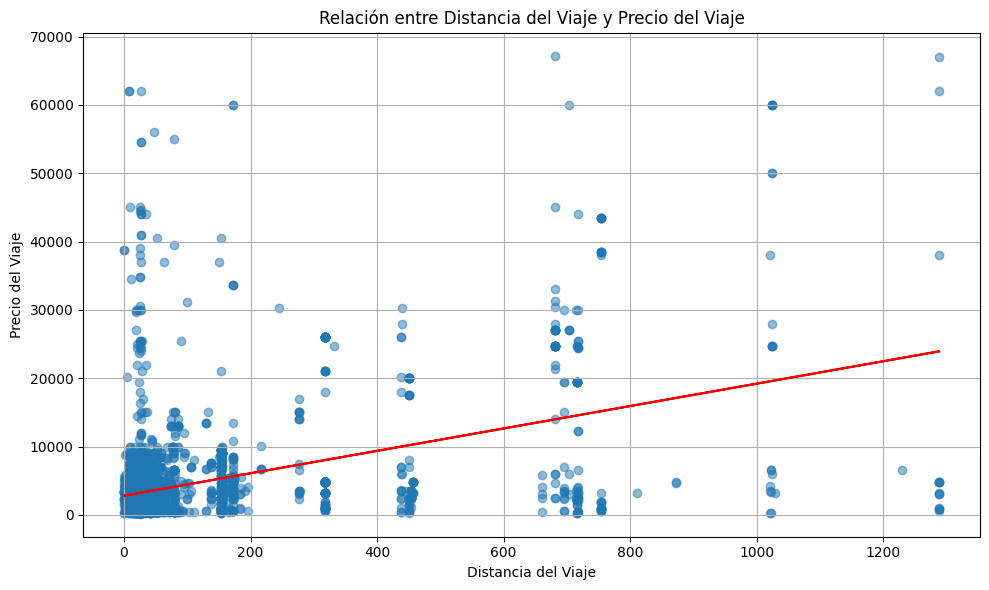

In [160]:
# Calcular la pendiente (m) e intersección (b) de la línea de tendencia
m, b = np.polyfit(df['distancia_km'], df['Precio_Viaje'], 1)

# Graficar el diagrama de dispersión
plt.figure(figsize=(10, 6))
plt.scatter(df['distancia_km'], df['Precio_Viaje'], alpha=0.5)
plt.plot(df['distancia_km'], m * df['distancia_km'] + b, color='red')
plt.xlabel('Distancia del Viaje')
plt.ylabel('Precio del Viaje')
plt.title('Relación entre Distancia del Viaje y Precio del Viaje')
plt.grid(True)
plt.tight_layout()
plt.show()

- Vemos que aquí si existe una correlación positiva entre distancia y viaje, lo cual suena correcto por el consumo de combustible


Ya terminado el Exploratory Data Analysis podemos proceder a la preparación de los datos para el modelo.